In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 09 - CNN with Fibonacci 

### v4 Ensemble

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Test on stage 2 data.

Original model: 'model_7_CNN_with_Fibonacci_8_mean_absolute_error_1_stage_2'

Ensemble: automatically evaluate the same model 4 times

In [326]:
model_name = 'model_9_CNN_with_Fibonacci_4_Ensemble_1_explore'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_2.csv'

In [5]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_2.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

In [12]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [13]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

weekday(X_input_first_day), weekday(X_output_first_day)

Both are Wednesday (2).

#### Y

In [14]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [15]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

daydiff(Y_input_first_day, Y_input_final_day)

In [16]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [17]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

weekday(Y_input_first_day), weekday(Y_output_first_day)

Both are Sunday (6).

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [19]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [20]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [21]:
fib_output_data = input_df[fib_output_dates].values; fib_output_data

array([[  49.,   10.,   19., ...,   32.,   34.,   21.],
       [  30.,   16.,   54., ...,  127.,  104.,   20.],
       [   7.,    2.,    1., ...,    5.,    5.,    0.],
       ..., 
       [  nan,   nan,   nan, ...,   35.,   46.,   43.],
       [  nan,   nan,   nan, ...,    6.,    6.,    7.],
       [  nan,   nan,   nan, ...,   21.,   20.,   14.]])

In [22]:
fib_input_data = input_df[fib_input_dates].values; fib_input_data

array([[  4.,  11.,  10., ...,  18.,  23.,  12.],
       [  2.,  23.,  12., ...,  24.,  16.,  15.],
       [  5.,   1.,   4., ...,   5.,   1.,   4.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

#### Fibonacci median in each window

In [23]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [24]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [25]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [26]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [27]:
fib_input_median

array([ 16.5 ,  15.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

In [28]:
fib_output_median

array([ 24.  ,  22.5 ,   4.  , ...,  34.  ,   7.75,  11.25])

We will use this as the center and part of the result

In [29]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

input_data contains X_input and Y_input array

In [30]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates, X_input_first_day, Y_input_final_day

(Index(['2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
        '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
        ...
        '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
        '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01'],
       dtype='object', length=126), '2016-04-29', '2016-09-01')

In [31]:
input_data = input_df[input_dates].values; #input_data  # input_data with nan

##### Convert nan to number 0.

In [32]:
input_data_num = np.nan_to_num(input_data); #input_data_num  # intput_data with nan -> 0.

input_data_num.shape

### Output Data

output_data for this self-testing script contains both X_output and Y_output

In [33]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates, X_output_first_day, X_output_final_day, Y_output_final_day

(Index(['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
        '2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07',
        ...
        '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
        '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
       dtype='object', length=126), '2017-04-28', '2017-06-29', '2017-08-31')

In [34]:
output_dates.shape

(126,)

In [35]:
output_data = input_df[output_dates].values; #output_data

##### Convert nan to number 0.

In [36]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]])

In [37]:
output_data_num.shape

(145063, 126)

### View

def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
        
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
    
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [38]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [39]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [40]:
input_data_log.shape, input_data.shape, output_data_log.shape, output_data.shape

((145063, 126), (145063, 126), (145063, 126), (145063, 126))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [41]:
gc.collect()

283

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [42]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [43]:
input_center, output_center

(array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]), array([[ 1.39794001],
        [ 1.37106786],
        [ 0.69897   ],
        ..., 
        [ 1.54406804],
        [ 0.94200805],
        [ 1.08813609]]))

#### Choice of default scale

In [44]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

In [45]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041809557845

In [46]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425448559207598

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [47]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22042467],
       [ 0.1944303 ],
       [ 0.23390395],
       ..., 
       [ 0.17974042],
       [ 0.17974042],
       [ 0.17974042]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [48]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.15715761],
       [ 0.23019142],
       [ 0.29932548],
       ..., 
       [ 0.30635028],
       [ 0.308769  ],
       [ 0.41433723]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [49]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [50]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [51]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [52]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [53]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
#input_gp, output_gp

In [54]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
#gp_input_counts

In [55]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
#gp_output_counts

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [56]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [57]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [58]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [59]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

X_input = X_input
Y_input = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

X_input_ori = X_input_ori
Y_input_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [60]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.945597725 182.183688699 0.0250217121081 3.34816141728
(145063, 63) -104.945597725 181.969627538 -0.0156385758122 3.42135990909
(145063, 63) -57.3465699314 8.00100800101 0.0 1.27077605981
(145063, 63) -1627.7382547 51.3918797946 -0.214767758227 6.0365527548
(145063, 63) 0.0 23209383.0 126.0 63765.8619057
(145063, 63) 0.0 67264258.0 128.0 155483.953622
(145063, 63) 0.0 24630674.0 123.0 65785.6552263
(145063, 63) 0.0 18670230.0 113.0 57469.0537846


#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [61]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [62]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [63]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [64]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), 1e-07, None))
    return 200. * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [66]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39849931396679, 148.1903381452849, 0.0)

In [67]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.417294139521594, 58.828327132034431)

In [68]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386336667 142.088333627


In [69]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.3250071896
40.4041165988


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [70]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

In [71]:
n_ens = 5
ens_list = list(range(n_ens))

In [72]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,))
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_t = Flatten()(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        model = Model(inputs=layer_0, outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 1: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 2: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 3: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 4: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 


In [73]:
models_ens[0][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 120)           720       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 120)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3480)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               417720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
__________

In [74]:
np.array(models_ens).shape

(5, 6)

In [75]:
len(gp_list)

6

In [76]:
epochs_list = [1,1,40,40,60,80]  # change to smaller epochs later (1,1,20,40,60,80)

In [77]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list):
        print('-- Group:', gp, '/', len(gp_list), '--')
        hist = model.fit(X_in, Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 0 / 5 ===
-- Group: 0 / 6 --
Train on 1691 samples, validate on 188 samples
Epoch 1/1
2s - loss: 0.9405 - k_smape: 196.7431 - val_loss: 0.9781 - val_k_smape: 199.9609
-- Group: 1 / 6 --
Train on 20776 samples, validate on 2309 samples
Epoch 1/1
3s - loss: 1.1344 - k_smape: 143.9056 - val_loss: 0.9810 - val_k_smape: 133.6400
-- Group: 2 / 6 --
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
7s - loss: 1.3234 - k_smape: 127.1297 - val_loss: 1.0211 - val_k_smape: 119.6731
Epoch 2/40
6s - loss: 1.2454 - k_smape: 118.1218 - val_loss: 1.0915 - val_k_smape: 126.3741
Epoch 3/40
6s - loss: 1.2327 - k_smape: 116.8031 - val_loss: 1.0156 - val_k_smape: 115.8677
Epoch 4/40
6s - loss: 1.2243 - k_smape: 115.5031 - val_loss: 1.0203 - val_k_smape: 116.7652
Epoch 5/40
6s - loss: 1.2115 - k_smape: 114.7533 - val_loss: 1.0366 - val_k_smape: 118.5249
Epoch 6/40
6s - loss: 1.2078 - k_smape: 114.5355 - val_loss: 1.0145 - val_k_smape: 114.4526
Epoch 7/40
6s - loss: 1.2089 - k_smape: 114.2

0s - loss: 2.0675 - k_smape: 118.0993 - val_loss: 2.2151 - val_k_smape: 119.1309
Epoch 6/60
0s - loss: 1.9903 - k_smape: 115.6568 - val_loss: 1.9787 - val_k_smape: 112.9946
Epoch 7/60
0s - loss: 1.8697 - k_smape: 109.5942 - val_loss: 1.8051 - val_k_smape: 111.1736
Epoch 8/60
0s - loss: 1.8777 - k_smape: 107.9605 - val_loss: 1.6535 - val_k_smape: 111.0716
Epoch 9/60
0s - loss: 1.8206 - k_smape: 106.1434 - val_loss: 1.9068 - val_k_smape: 112.3038
Epoch 10/60
0s - loss: 1.8015 - k_smape: 103.7454 - val_loss: 1.6774 - val_k_smape: 105.7290
Epoch 11/60
0s - loss: 1.7304 - k_smape: 102.9216 - val_loss: 1.7526 - val_k_smape: 106.2698
Epoch 12/60
0s - loss: 1.7251 - k_smape: 101.2661 - val_loss: 1.7874 - val_k_smape: 110.2524
Epoch 13/60
0s - loss: 1.6479 - k_smape: 101.6158 - val_loss: 1.4688 - val_k_smape: 102.2052
Epoch 14/60
0s - loss: 1.6464 - k_smape: 97.0038 - val_loss: 1.7082 - val_k_smape: 103.0187
Epoch 15/60
0s - loss: 1.6625 - k_smape: 98.1035 - val_loss: 1.8220 - val_k_smape: 107.

0s - loss: 3.5105 - k_smape: 93.6484 - val_loss: 1.7329 - val_k_smape: 95.6483
Epoch 46/80
0s - loss: 3.3138 - k_smape: 88.0004 - val_loss: 1.5696 - val_k_smape: 94.1646
Epoch 47/80
0s - loss: 3.2033 - k_smape: 87.6000 - val_loss: 1.5265 - val_k_smape: 93.3084
Epoch 48/80
0s - loss: 3.4904 - k_smape: 91.8652 - val_loss: 1.3745 - val_k_smape: 92.6445
Epoch 49/80
0s - loss: 3.1035 - k_smape: 86.2753 - val_loss: 1.3947 - val_k_smape: 93.4813
Epoch 50/80
0s - loss: 3.1850 - k_smape: 87.4940 - val_loss: 1.4342 - val_k_smape: 93.5602
Epoch 51/80
0s - loss: 3.4050 - k_smape: 89.0196 - val_loss: 1.4561 - val_k_smape: 93.0023
Epoch 52/80
0s - loss: 3.1728 - k_smape: 84.5707 - val_loss: 1.5567 - val_k_smape: 92.2589
Epoch 53/80
0s - loss: 3.3070 - k_smape: 87.9454 - val_loss: 1.5719 - val_k_smape: 91.4527
Epoch 54/80
0s - loss: 3.3962 - k_smape: 88.6530 - val_loss: 1.4881 - val_k_smape: 90.0895
Epoch 55/80
0s - loss: 3.1680 - k_smape: 82.7892 - val_loss: 1.3531 - val_k_smape: 88.6992
Epoch 56/80

11s - loss: 1.1897 - k_smape: 97.1949 - val_loss: 1.0873 - val_k_smape: 106.1256
Epoch 10/40
11s - loss: 1.1948 - k_smape: 97.1212 - val_loss: 1.0809 - val_k_smape: 105.7302
Epoch 11/40
11s - loss: 1.1883 - k_smape: 96.9191 - val_loss: 1.0725 - val_k_smape: 105.4289
Epoch 12/40
11s - loss: 1.1829 - k_smape: 96.7693 - val_loss: 1.0744 - val_k_smape: 103.8135
Epoch 13/40
11s - loss: 1.1808 - k_smape: 96.5277 - val_loss: 1.1091 - val_k_smape: 106.6174
Epoch 14/40
11s - loss: 1.1806 - k_smape: 96.4593 - val_loss: 1.0615 - val_k_smape: 104.2114
Epoch 15/40
11s - loss: 1.1740 - k_smape: 96.4268 - val_loss: 1.0944 - val_k_smape: 103.8361
Epoch 16/40
11s - loss: 1.1725 - k_smape: 96.0262 - val_loss: 1.0707 - val_k_smape: 104.0363
Epoch 17/40
11s - loss: 1.1719 - k_smape: 96.0650 - val_loss: 1.0830 - val_k_smape: 105.2203
Epoch 18/40
11s - loss: 1.1717 - k_smape: 95.9167 - val_loss: 1.0821 - val_k_smape: 105.4576
Epoch 19/40
11s - loss: 1.1649 - k_smape: 95.5820 - val_loss: 1.0956 - val_k_smape

0s - loss: 1.3633 - k_smape: 80.2877 - val_loss: 1.2506 - val_k_smape: 86.1780
Epoch 60/60
0s - loss: 1.2687 - k_smape: 78.5744 - val_loss: 1.4610 - val_k_smape: 89.5282
-- Group: 5 / 6 --
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8573 - k_smape: 178.2474 - val_loss: 4.7734 - val_k_smape: 170.7466
Epoch 2/80
0s - loss: 6.5331 - k_smape: 167.0395 - val_loss: 4.6305 - val_k_smape: 158.2498
Epoch 3/80
0s - loss: 6.3439 - k_smape: 156.3756 - val_loss: 4.4827 - val_k_smape: 151.4409
Epoch 4/80
0s - loss: 6.0130 - k_smape: 147.6448 - val_loss: 4.2887 - val_k_smape: 145.1495
Epoch 5/80
0s - loss: 5.8955 - k_smape: 140.9863 - val_loss: 4.0696 - val_k_smape: 139.0153
Epoch 6/80
0s - loss: 5.9732 - k_smape: 139.0476 - val_loss: 3.8598 - val_k_smape: 133.8209
Epoch 7/80
0s - loss: 5.6414 - k_smape: 134.5819 - val_loss: 3.6636 - val_k_smape: 129.1762
Epoch 8/80
0s - loss: 5.6507 - k_smape: 133.6635 - val_loss: 3.5204 - val_k_smape: 127.2636
Epoch 9/80
0s - loss: 5.4031 - k

6s - loss: 1.2193 - k_smape: 115.5703 - val_loss: 1.0108 - val_k_smape: 115.2820
Epoch 5/40
6s - loss: 1.2155 - k_smape: 114.8818 - val_loss: 1.0272 - val_k_smape: 118.8090
Epoch 6/40
6s - loss: 1.2120 - k_smape: 114.8179 - val_loss: 1.0309 - val_k_smape: 117.7386
Epoch 7/40
6s - loss: 1.2116 - k_smape: 114.3603 - val_loss: 1.0430 - val_k_smape: 119.0264
Epoch 8/40
6s - loss: 1.1990 - k_smape: 113.7934 - val_loss: 1.0128 - val_k_smape: 113.6000
Epoch 9/40
6s - loss: 1.2028 - k_smape: 113.9256 - val_loss: 1.0311 - val_k_smape: 115.4928
Epoch 10/40
6s - loss: 1.2000 - k_smape: 113.4990 - val_loss: 1.0087 - val_k_smape: 114.3770
Epoch 11/40
6s - loss: 1.1913 - k_smape: 113.4040 - val_loss: 1.0179 - val_k_smape: 116.7078
Epoch 12/40
6s - loss: 1.1977 - k_smape: 113.3965 - val_loss: 1.0806 - val_k_smape: 122.2375
Epoch 13/40
6s - loss: 1.1954 - k_smape: 113.1580 - val_loss: 1.0225 - val_k_smape: 117.5682
Epoch 14/40
6s - loss: 1.1888 - k_smape: 113.0720 - val_loss: 1.0381 - val_k_smape: 119

0s - loss: 1.7095 - k_smape: 101.9785 - val_loss: 1.6213 - val_k_smape: 102.4768
Epoch 12/60
0s - loss: 1.6602 - k_smape: 98.4021 - val_loss: 1.7565 - val_k_smape: 106.0181
Epoch 13/60
0s - loss: 1.6444 - k_smape: 97.4569 - val_loss: 1.4689 - val_k_smape: 99.8339
Epoch 14/60
0s - loss: 1.6742 - k_smape: 96.7198 - val_loss: 1.8985 - val_k_smape: 106.6073
Epoch 15/60
0s - loss: 1.6305 - k_smape: 96.4679 - val_loss: 1.4866 - val_k_smape: 96.2873
Epoch 16/60
0s - loss: 1.6418 - k_smape: 93.5327 - val_loss: 2.0572 - val_k_smape: 111.4488
Epoch 17/60
0s - loss: 1.6843 - k_smape: 99.0364 - val_loss: 1.4266 - val_k_smape: 96.0672
Epoch 18/60
0s - loss: 1.5787 - k_smape: 91.5033 - val_loss: 1.7066 - val_k_smape: 100.2116
Epoch 19/60
0s - loss: 1.5805 - k_smape: 92.3072 - val_loss: 1.4416 - val_k_smape: 95.8652
Epoch 20/60
0s - loss: 1.5043 - k_smape: 91.2996 - val_loss: 1.6849 - val_k_smape: 99.1584
Epoch 21/60
0s - loss: 1.5725 - k_smape: 89.9823 - val_loss: 1.4571 - val_k_smape: 95.8605
Epoch

0s - loss: 3.6516 - k_smape: 97.1988 - val_loss: 1.1608 - val_k_smape: 96.0943
Epoch 46/80
0s - loss: 3.5018 - k_smape: 93.4190 - val_loss: 1.1684 - val_k_smape: 93.4909
Epoch 47/80
0s - loss: 3.4646 - k_smape: 88.5564 - val_loss: 1.2624 - val_k_smape: 92.0699
Epoch 48/80
0s - loss: 3.1529 - k_smape: 88.1046 - val_loss: 1.4805 - val_k_smape: 92.3816
Epoch 49/80
0s - loss: 3.4234 - k_smape: 91.9841 - val_loss: 1.6753 - val_k_smape: 93.7772
Epoch 50/80
0s - loss: 3.3712 - k_smape: 90.2310 - val_loss: 1.8236 - val_k_smape: 94.9899
Epoch 51/80
0s - loss: 3.2006 - k_smape: 88.8696 - val_loss: 1.8066 - val_k_smape: 95.1161
Epoch 52/80
0s - loss: 3.3478 - k_smape: 89.7741 - val_loss: 1.6417 - val_k_smape: 94.0722
Epoch 53/80
0s - loss: 3.3791 - k_smape: 90.9064 - val_loss: 1.3328 - val_k_smape: 93.8571
Epoch 54/80
0s - loss: 3.2380 - k_smape: 88.7968 - val_loss: 1.0407 - val_k_smape: 92.1012
Epoch 55/80
0s - loss: 3.1698 - k_smape: 84.5010 - val_loss: 1.0114 - val_k_smape: 92.6805
Epoch 56/80

11s - loss: 1.1880 - k_smape: 97.1350 - val_loss: 1.0981 - val_k_smape: 107.3523
Epoch 10/40
11s - loss: 1.1827 - k_smape: 96.8246 - val_loss: 1.0659 - val_k_smape: 104.8008
Epoch 11/40
11s - loss: 1.1828 - k_smape: 96.6672 - val_loss: 1.0788 - val_k_smape: 105.9261
Epoch 12/40
11s - loss: 1.1786 - k_smape: 96.4244 - val_loss: 1.0700 - val_k_smape: 105.6081
Epoch 13/40
11s - loss: 1.1727 - k_smape: 96.2699 - val_loss: 1.0642 - val_k_smape: 105.7233
Epoch 14/40
11s - loss: 1.1717 - k_smape: 96.0378 - val_loss: 1.0906 - val_k_smape: 105.8850
Epoch 15/40
11s - loss: 1.1713 - k_smape: 95.9889 - val_loss: 1.0573 - val_k_smape: 104.2274
Epoch 16/40
11s - loss: 1.1657 - k_smape: 95.7829 - val_loss: 1.0577 - val_k_smape: 105.0411
Epoch 17/40
11s - loss: 1.1621 - k_smape: 95.5363 - val_loss: 1.0743 - val_k_smape: 106.2161
Epoch 18/40
11s - loss: 1.1607 - k_smape: 95.3971 - val_loss: 1.0974 - val_k_smape: 105.6251
Epoch 19/40
11s - loss: 1.1580 - k_smape: 95.2036 - val_loss: 1.0717 - val_k_smape

0s - loss: 1.2413 - k_smape: 76.7908 - val_loss: 1.2546 - val_k_smape: 86.6679
Epoch 60/60
0s - loss: 1.2870 - k_smape: 79.8510 - val_loss: 1.3225 - val_k_smape: 87.3708
-- Group: 5 / 6 --
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8495 - k_smape: 175.7314 - val_loss: 4.7401 - val_k_smape: 168.5517
Epoch 2/80
0s - loss: 6.5719 - k_smape: 164.5876 - val_loss: 4.5651 - val_k_smape: 160.3808
Epoch 3/80
0s - loss: 6.2344 - k_smape: 153.7104 - val_loss: 4.3898 - val_k_smape: 151.0089
Epoch 4/80
0s - loss: 5.8309 - k_smape: 144.0903 - val_loss: 4.1605 - val_k_smape: 142.5544
Epoch 5/80
0s - loss: 5.8356 - k_smape: 139.3894 - val_loss: 3.9325 - val_k_smape: 135.3378
Epoch 6/80
0s - loss: 5.5414 - k_smape: 135.0769 - val_loss: 3.7571 - val_k_smape: 131.0428
Epoch 7/80
0s - loss: 5.5853 - k_smape: 133.9833 - val_loss: 3.6108 - val_k_smape: 128.9585
Epoch 8/80
0s - loss: 5.4402 - k_smape: 129.3464 - val_loss: 3.4925 - val_k_smape: 127.9053
Epoch 9/80
0s - loss: 5.3417 - k

6s - loss: 1.2197 - k_smape: 115.5278 - val_loss: 1.0222 - val_k_smape: 119.2275
Epoch 5/40
6s - loss: 1.2125 - k_smape: 115.0711 - val_loss: 1.0073 - val_k_smape: 116.5493
Epoch 6/40
6s - loss: 1.2098 - k_smape: 114.6810 - val_loss: 1.0522 - val_k_smape: 120.8611
Epoch 7/40
6s - loss: 1.2105 - k_smape: 114.5261 - val_loss: 1.0446 - val_k_smape: 118.0752
Epoch 8/40
6s - loss: 1.2045 - k_smape: 114.1227 - val_loss: 1.0359 - val_k_smape: 116.3700
Epoch 9/40
6s - loss: 1.1988 - k_smape: 113.8242 - val_loss: 1.0538 - val_k_smape: 123.5545
Epoch 10/40
6s - loss: 1.1984 - k_smape: 113.7015 - val_loss: 1.0826 - val_k_smape: 120.1719
Epoch 11/40
6s - loss: 1.1939 - k_smape: 113.2075 - val_loss: 1.0391 - val_k_smape: 120.0709
Epoch 12/40
6s - loss: 1.1966 - k_smape: 113.3718 - val_loss: 1.0240 - val_k_smape: 114.8458
Epoch 13/40
6s - loss: 1.1880 - k_smape: 113.0648 - val_loss: 1.0491 - val_k_smape: 119.3744
Epoch 14/40
6s - loss: 1.1857 - k_smape: 112.8161 - val_loss: 1.0508 - val_k_smape: 118

0s - loss: 1.6995 - k_smape: 100.9879 - val_loss: 1.6845 - val_k_smape: 107.6010
Epoch 12/60
0s - loss: 1.6700 - k_smape: 100.7067 - val_loss: 1.9631 - val_k_smape: 111.1718
Epoch 13/60
0s - loss: 1.6725 - k_smape: 96.8033 - val_loss: 1.5291 - val_k_smape: 104.4896
Epoch 14/60
0s - loss: 1.6496 - k_smape: 99.0185 - val_loss: 1.5397 - val_k_smape: 104.8105
Epoch 15/60
0s - loss: 1.5878 - k_smape: 96.7965 - val_loss: 1.4058 - val_k_smape: 99.5499
Epoch 16/60
0s - loss: 1.5928 - k_smape: 95.3643 - val_loss: 1.7207 - val_k_smape: 103.1863
Epoch 17/60
0s - loss: 1.6500 - k_smape: 92.2455 - val_loss: 1.5168 - val_k_smape: 99.0210
Epoch 18/60
0s - loss: 1.5977 - k_smape: 95.9103 - val_loss: 1.5907 - val_k_smape: 98.2656
Epoch 19/60
0s - loss: 1.6517 - k_smape: 92.3780 - val_loss: 2.0873 - val_k_smape: 106.5464
Epoch 20/60
0s - loss: 1.6084 - k_smape: 94.0488 - val_loss: 1.4148 - val_k_smape: 95.0744
Epoch 21/60
0s - loss: 1.5416 - k_smape: 91.2928 - val_loss: 1.5972 - val_k_smape: 98.2606
Epo

0s - loss: 3.4129 - k_smape: 93.0138 - val_loss: 1.5239 - val_k_smape: 98.7998
Epoch 44/80
0s - loss: 3.4670 - k_smape: 93.0716 - val_loss: 1.4703 - val_k_smape: 98.3099
Epoch 45/80
0s - loss: 3.4107 - k_smape: 91.8797 - val_loss: 1.5257 - val_k_smape: 98.2959
Epoch 46/80
0s - loss: 3.6361 - k_smape: 93.0251 - val_loss: 1.5771 - val_k_smape: 98.0690
Epoch 47/80
0s - loss: 3.2439 - k_smape: 92.2252 - val_loss: 1.5446 - val_k_smape: 96.7792
Epoch 48/80
0s - loss: 3.3866 - k_smape: 92.7531 - val_loss: 1.4942 - val_k_smape: 95.4544
Epoch 49/80
0s - loss: 3.2095 - k_smape: 87.1266 - val_loss: 1.4973 - val_k_smape: 95.0087
Epoch 50/80
0s - loss: 3.2258 - k_smape: 90.2974 - val_loss: 1.4497 - val_k_smape: 94.3927
Epoch 51/80
0s - loss: 3.4274 - k_smape: 87.7669 - val_loss: 1.4408 - val_k_smape: 93.7045
Epoch 52/80
0s - loss: 3.1928 - k_smape: 87.7660 - val_loss: 1.4559 - val_k_smape: 93.8006
Epoch 53/80
0s - loss: 3.6041 - k_smape: 89.6230 - val_loss: 1.5048 - val_k_smape: 93.5778
Epoch 54/80

### Training History

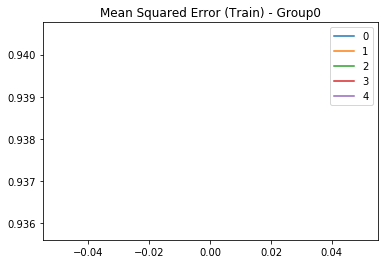

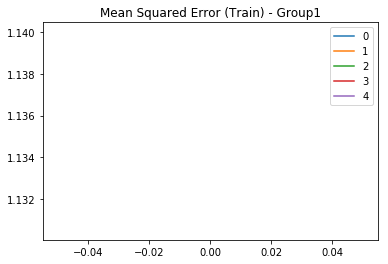

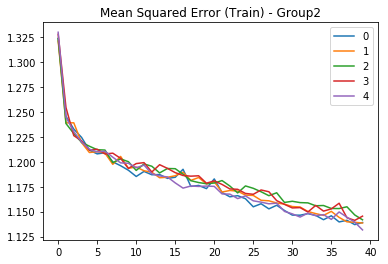

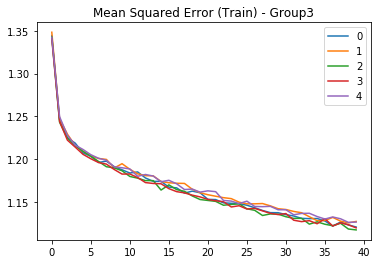

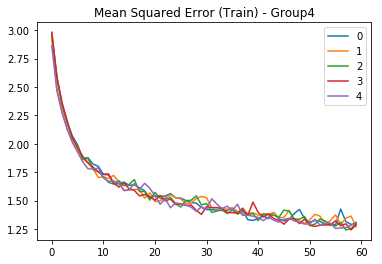

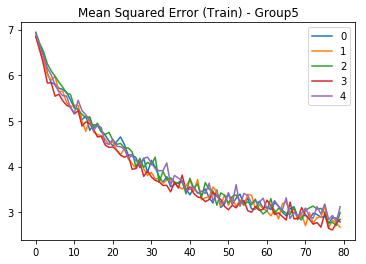

In [78]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

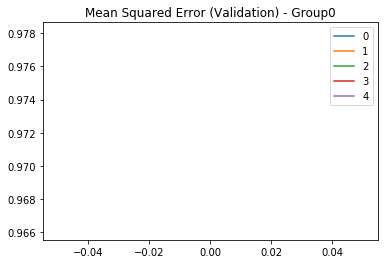

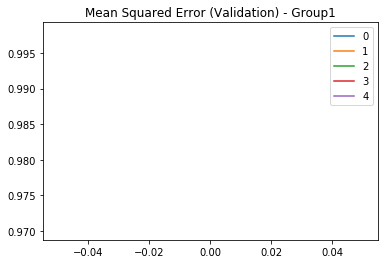

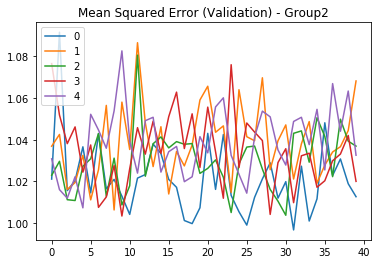

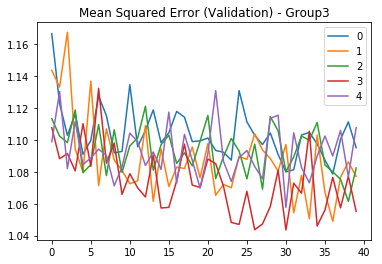

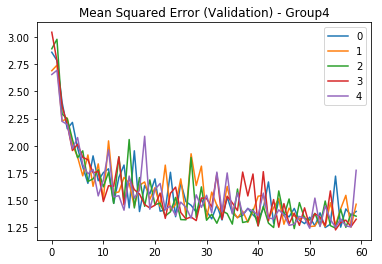

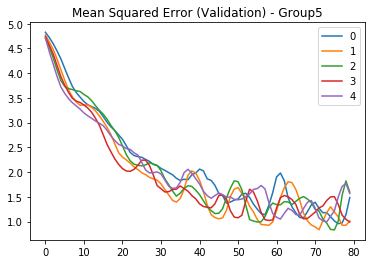

In [79]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

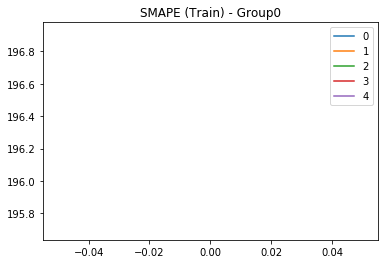

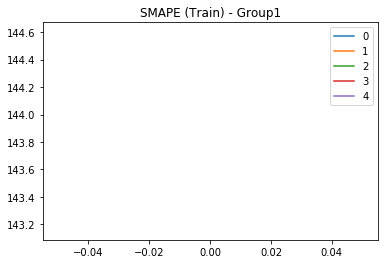

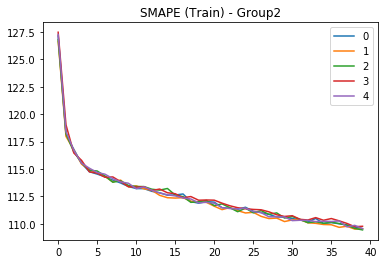

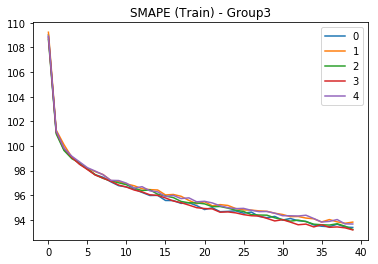

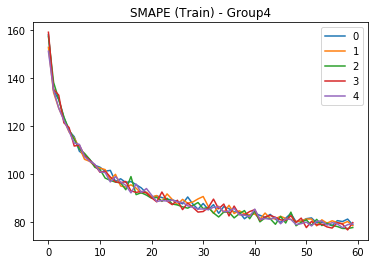

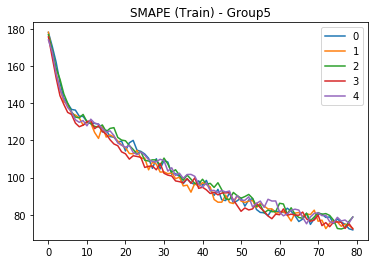

In [80]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group' + str(gp))
        plt.legend(); plt.show()        

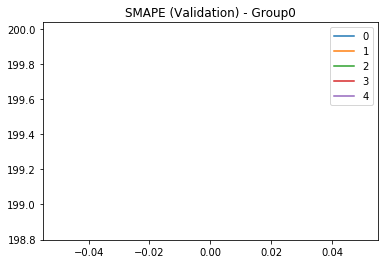

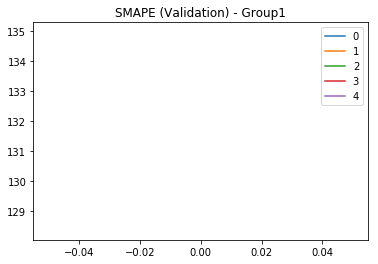

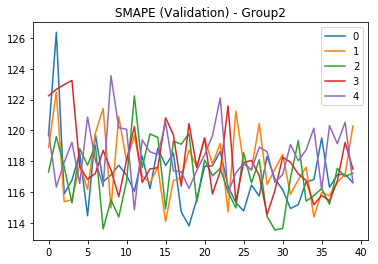

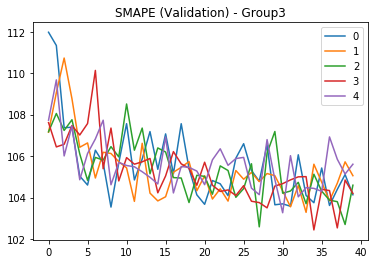

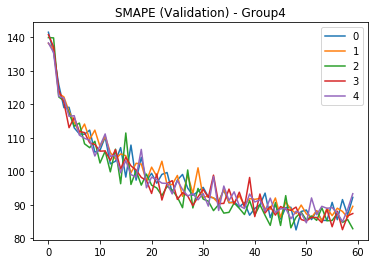

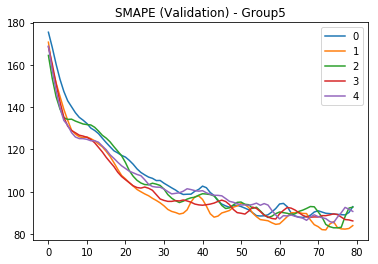

In [81]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group' + str(gp))
        plt.legend(); plt.show()        

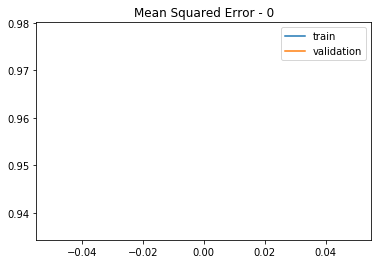

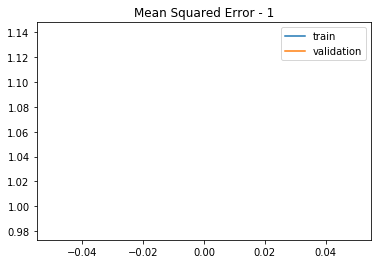

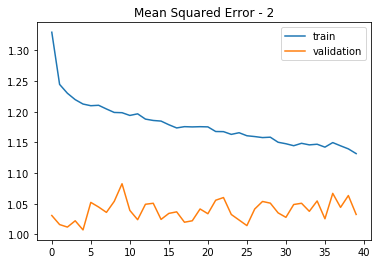

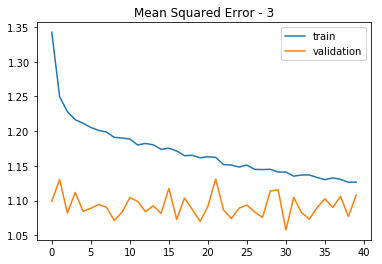

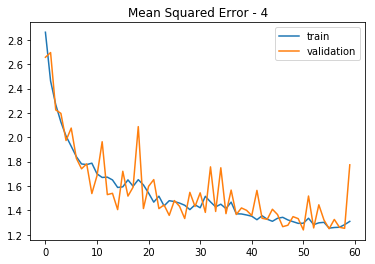

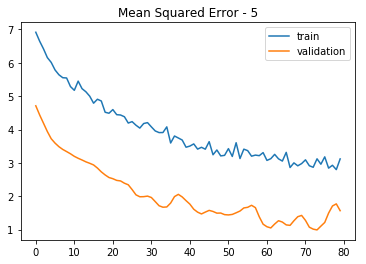

In [82]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

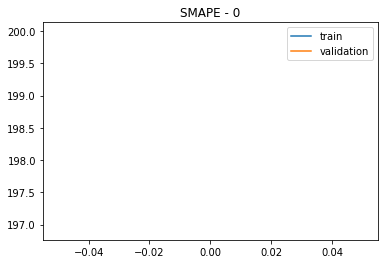

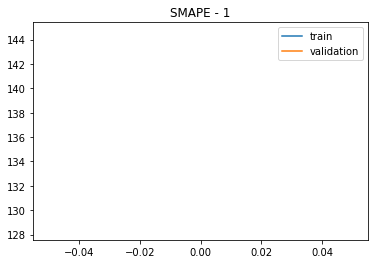

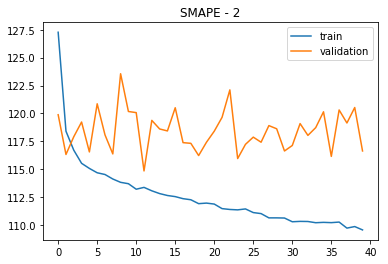

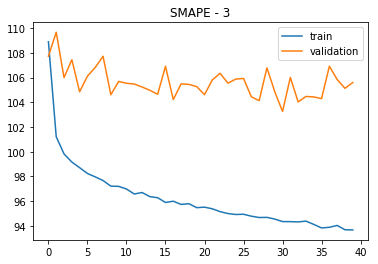

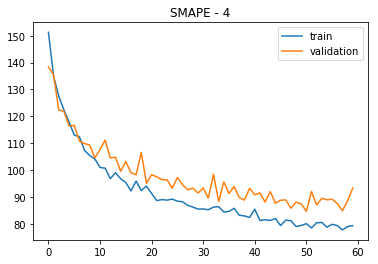

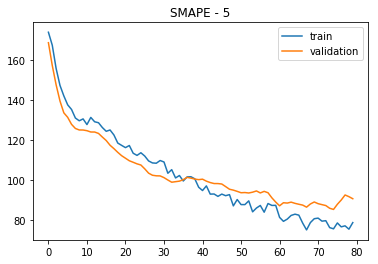

In [83]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

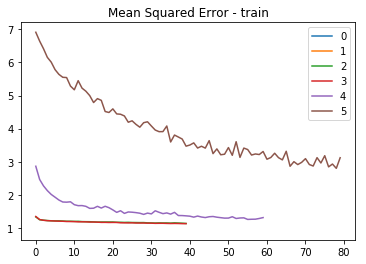

In [84]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

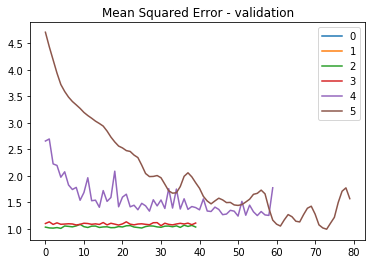

In [85]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

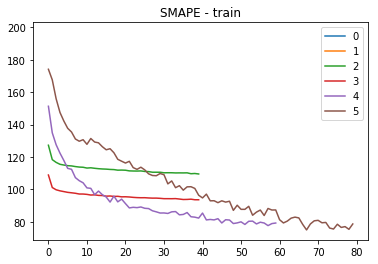

In [86]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

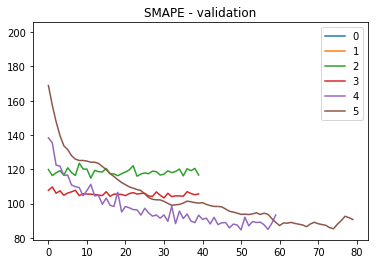

In [87]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using Output Set

if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [88]:
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X) in zip(gp_list, models, X_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict(X))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 4 5 
Run 1: 0 1 2 3 4 5 
Run 2: 0 1 2 3 4 5 
Run 3: 0 1 2 3 4 5 
Run 4: 0 1 2 3 4 5 


Find the original index

In [89]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [90]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [91]:
for o in output_index_list:
    print(o.shape)

(1879,)
(23085,)
(43691,)
(75617,)
(740,)
(51,)


In [92]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([  1475,   3412,   3467, ..., 123025, 139119, 140151])

In [93]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred_temp = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred_temp[index] = y

    Y_output_pred = np.array(Y_output_pred_temp)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_temp

In [94]:
# Inverse transform Y of output

Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          output_center, output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

### Model Score

In [95]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape, model_smape_0)
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    print('-----------')
    print(model_smape_ens_mean, model_smape_0_ens_mean)

39.131548328 42.9506952071
39.0737876074 42.8285840083
38.9784618434 42.5319008258
39.2203630382 42.8780741808
39.3695486694 43.0435641086
-----------
39.1547418973 42.8465636661


In [96]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

40.4041165988


### Group Scores
For self-testing stage only

In [97]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [98]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [99]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [100]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [101]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Individual Page Scores

In [102]:
if test_length:
    smape_Y_pred_ens = []
    #smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
    #                            in zip(Y_output_pred_ori, Y_output_raw)])
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


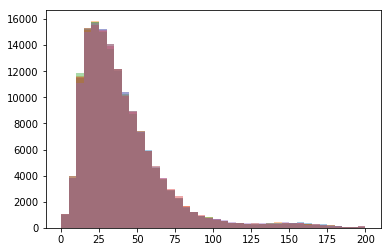

In [103]:
if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.show()

### SMAPE for the Model

In [104]:
if test_length:
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

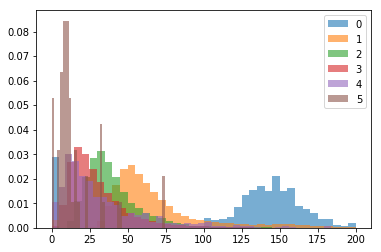

In [105]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

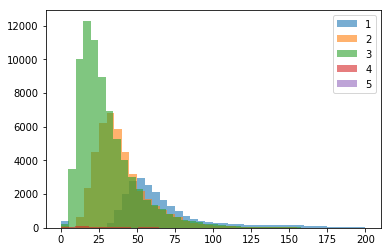

In [108]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

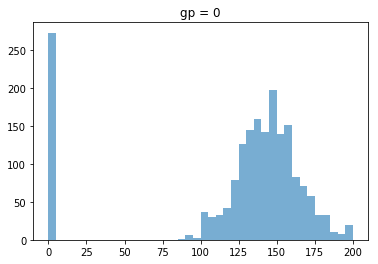

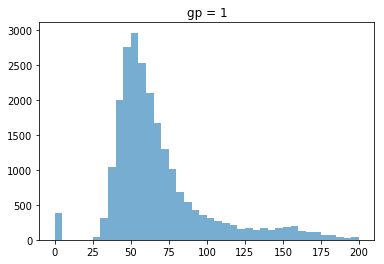

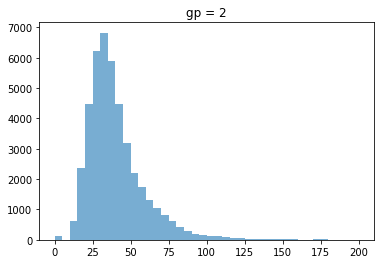

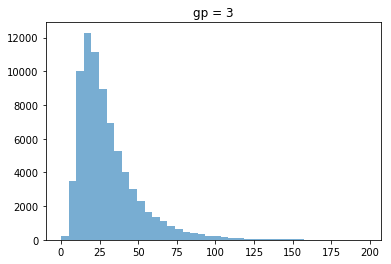

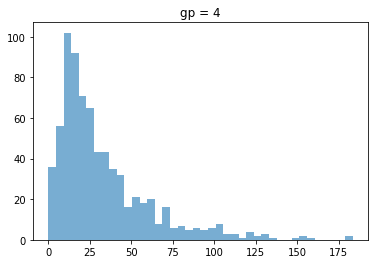

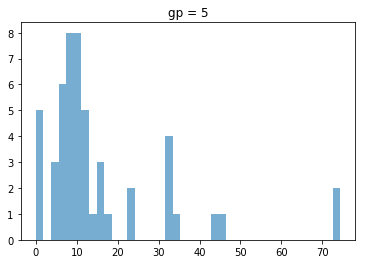

In [109]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### SMAPE for Fibonacci median

In [110]:
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [111]:
# Group SMAPE for Fib.
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [112]:
# Individual SMAPE for Fib.
if test_length:
    #smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
    #                           in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]
# The above two cells can be combined.

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


#### SMAPE distribution for Fib

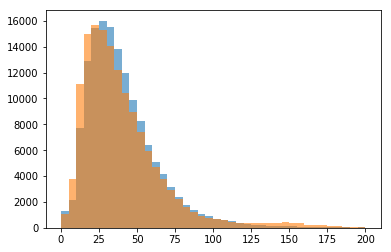

In [113]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

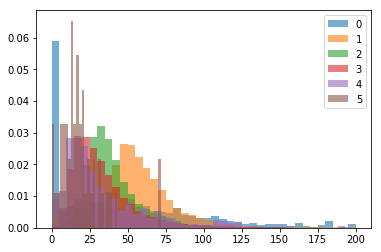

In [114]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

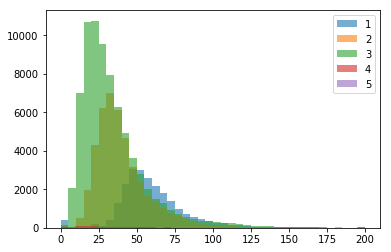

In [115]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

if test_length:
    for i in range(len(smape_Y_fib_list)):
        plt.hist(smape_Y_pred_list[i], bins=40, alpha=0.7, label='Model')
        plt.hist(smape_Y_fib_list[i], bins=40, alpha=0.5, label='Fib')
        plt.title('gp = '+str(i))
        plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

### Models vs Fibonacci Median

In [327]:
if test_length: # gp_score
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')

#### model_9_CNN_with_Fibonacci_4_Ensemble_1_explore
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 163.551 | 155.585 | 151.946 | 155.925 | 146.684 |
|  23085 |  61.354 |  63.734 |  63.826 |  64.022 |  64.426 |  64.808 |
|  43691 |  40.612 |  40.087 |  39.985 |  40.297 |  40.099 |  40.261 |
|  75617 |  34.284 |  30.096 |  30.147 |  29.776 |  30.179 |  30.390 |
|    740 |  35.621 |  35.697 |  33.872 |  34.453 |  34.514 |  33.908 |
|     51 |  20.224 |  16.618 |  16.189 |  16.770 |  16.863 |  16.613 |


#### model_9_CNN_with_Fibonacci_4_Ensemble_1_explore
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 163.551 | 155.585 | 151.946 | 155.925 | 146.684 |
|  23085 |  61.354 |  63.734 |  63.826 |  64.022 |  64.426 |  64.808 |
|  43691 |  40.612 |  40.087 |  39.985 |  40.297 |  40.099 |  40.261 |
|  75617 |  34.284 |  30.096 |  30.147 |  29.776 |  30.179 |  30.390 |
|    740 |  35.621 |  35.697 |  33.872 |  34.453 |  34.514 |  33.908 |
|     51 |  20.224 |  16.618 |  16.189 |  16.770 |  16.863 |  16.613 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [117]:
Y_output_fib.shape

(145063, 1)

In [118]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [119]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [120]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

In [121]:
Y_output_fmc_ori

array([[ 26.99592634,  26.93555772,  27.25976865, ...,  25.32989913,
         24.83248551,  25.23958202],
       [ 25.22890572,  25.60333714,  25.97506981, ...,  22.62507817,
         22.10157479,  22.61400432],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [ 28.56334497,  29.92426736,  30.50247803, ...,  28.98246952,
         28.32707634,  29.8125492 ],
       [  7.75      ,   7.75      ,   7.75      , ...,   7.75      ,
          7.75      ,   7.75      ],
       [ 10.9333334 ,  10.66667843,  10.98387779, ...,  10.91766369,
         10.46239092,  10.97570723]])

In [122]:
model_smape_ens

[39.131548327983054,
 39.073787607447834,
 38.978461843372081,
 39.220363038179848,
 39.369548669404288]

In [123]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [124]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

38.015 (39.132) - model_9_CNN_with_Fibonacci_4_Ensemble 0
38.001 (39.074) - model_9_CNN_with_Fibonacci_4_Ensemble 1
37.903 (38.978) - model_9_CNN_with_Fibonacci_4_Ensemble 2
38.056 (39.220) - model_9_CNN_with_Fibonacci_4_Ensemble 3
38.216 (39.370) - model_9_CNN_with_Fibonacci_4_Ensemble 4
38.038 (39.155) - model_9_CNN_with_Fibonacci_4_Ensemble Average


In [125]:
model_name

'model_9_CNN_with_Fibonacci_4_Ensemble'

#### Combined Scores:
38.777 (39.377) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 2

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.174 (44.159) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 3

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

43.038 (43.990) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 1

43.479 (44.659) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 3

43.804 (45.033) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.948 (46.090) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4

43.762 (44.885) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3

43.805 (44.996) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Ensemble Learning

In [126]:
Y_output_pred_ori_ens

[array([[ 27.30711776,  27.30401172,  27.92233648, ...,  26.87651128,
          26.38776236,  26.78603229],
        [ 26.65112758,  26.49172027,  27.02869133, ...,  24.24884851,
          23.65830638,  24.27926246],
        [  3.26429059,   3.67627402,   3.40704778, ...,   3.44147752,
           3.32884378,   3.49211804],
        ..., 
        [ 29.53510509,  30.67442302,  31.2369049 , ...,  29.47114764,
          28.72844326,  30.50849392],
        [  6.27757905,   6.87400479,   6.47204326, ...,   6.327504  ,
           6.32894774,   6.66750391],
        [ 10.24143356,   8.54689598,   9.14350181, ...,  11.71676122,
          11.32337013,  12.16901198]]),
 array([[ 23.0818773 ,  23.87013752,  24.52773946, ...,  23.44106278,
          23.0314373 ,  23.24093134],
        [ 26.65590512,  27.68650802,  28.43469862, ...,  23.87633719,
          23.3741954 ,  23.83235783],
        [  3.86664929,   4.18888943,   3.76915399, ...,   3.65504556,
           3.58837647,   3.82534164],
        ...,

### Method 1 - Mean

In [127]:
Y_output_pred_ori_ens_mean = np.mean(Y_output_pred_ori_ens, axis=0)

In [128]:
Y_output_pred_ori_ens_mean.shape

(145063, 63)

Y_output_pred_ori_ens_mean

In [129]:
smape(Y_output_pred_ori_ens_mean, Y_output_raw)

39.180826798191184

### Method 2 - Median

In [130]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)

In [131]:
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [132]:
smape(Y_output_pred_ori_ens_med, Y_output_raw)

38.878634504564303

### Method 3 - Mean before inverse transform and log

In [133]:
Y_output_pred_ens_mean = np.mean(Y_output_pred_ens, axis=0)
Y_output_pred_ens_mean_ori = unlog(untransform(Y_output_pred_ens_mean, output_center, output_scale))

In [134]:
smape(Y_output_pred_ens_mean_ori, Y_output_raw)

39.007502528323599

### Method 4 - Median before inverse transform and log

In [135]:
Y_output_pred_ens_med = np.median(Y_output_pred_ens, axis=0)
Y_output_pred_ens_med_ori = unlog(untransform(Y_output_pred_ens_med, output_center, output_scale))

In [136]:
smape(Y_output_pred_ens_med_ori, Y_output_raw)

38.878634504564303

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [137]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [138]:
# The combined result

Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
Y_output_pred_ens_med_ori

array([[ 26.76236899,  26.93555772,  27.25976865, ...,  25.51245545,
         25.01217901,  25.23958202],
       [ 26.65112758,  26.49172027,  27.02869133, ...,  23.87633719,
         23.3741954 ,  23.83235783],
       [  3.34215349,   3.71816973,   3.40704778, ...,   3.44147752,
          3.32884378,   3.51254448],
       ..., 
       [ 29.53510509,  30.67442302,  31.57013125, ...,  29.47114764,
         28.72844326,  30.50849392],
       [  6.64236553,   7.50110793,   6.65230875, ...,   6.66652042,
          6.66382209,   6.86221309],
       [ 15.63832897,  14.4148825 ,  14.87202979, ...,  14.43858691,
         13.9374666 ,  14.57549656]])

In [139]:
Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med
Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

In [323]:
if test_length:
    f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [328]:
if test_length: # The_score
    print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f         ' % f_omed_smape, '-', model_name, 'ori_ens_med')
    print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.760          - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore ori_ens_mean
37.648          - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore ori_ens_med
37.682          - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore ens_mean_ori
37.648          - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore ens_med_ori
38.038 (39.155) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore Average


In [329]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

38.015 (39.132) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore 0
38.001 (39.074) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore 1
37.903 (38.978) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore 2
38.056 (39.220) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore 3
38.216 (39.370) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore 4
38.038 (39.155) - model_9_CNN_with_Fibonacci_4_Ensemble_1_explore Average


Ensemble of model are all better than the individual model.

In [142]:
fmc_smape_ens_mean

38.038133758846513

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

### Plots

In [143]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

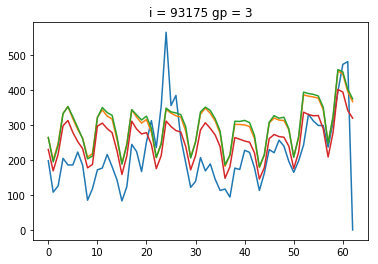

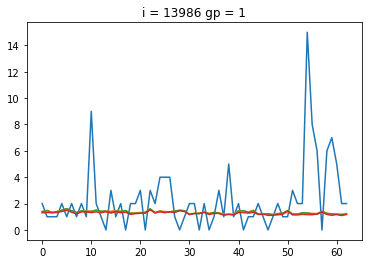

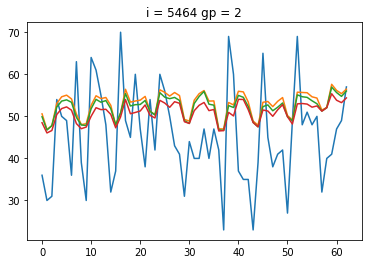

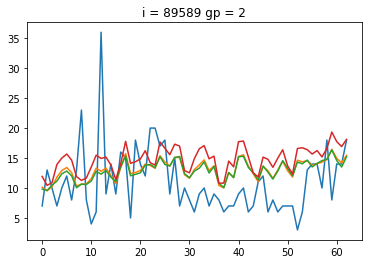

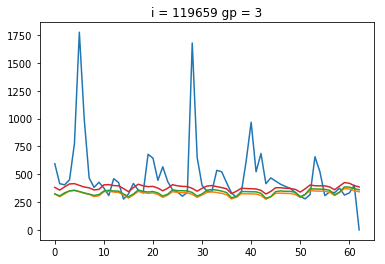

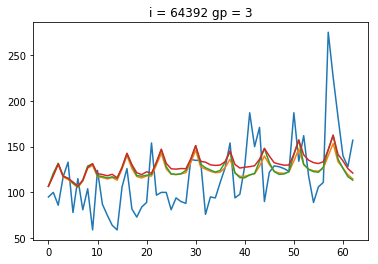

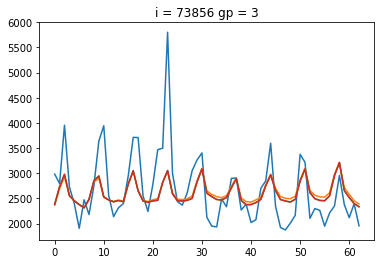

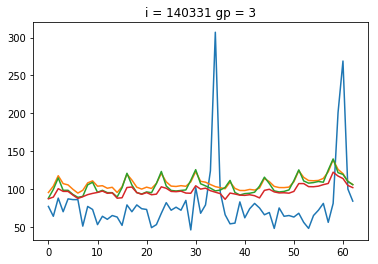

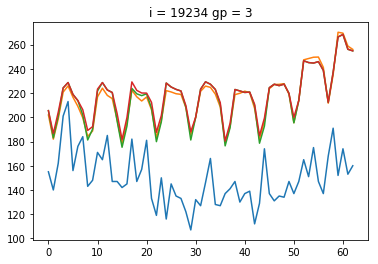

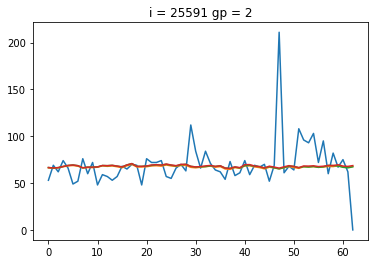

In [192]:
view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

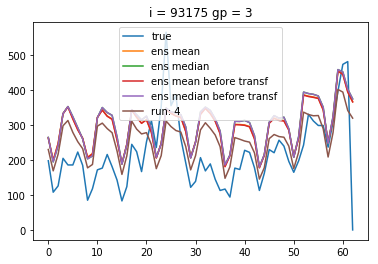

In [145]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

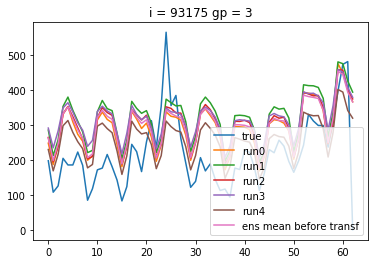

In [146]:
i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

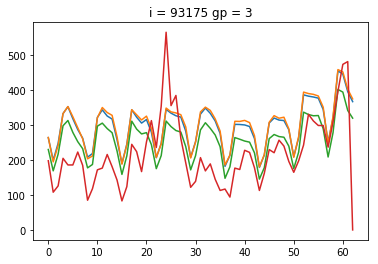

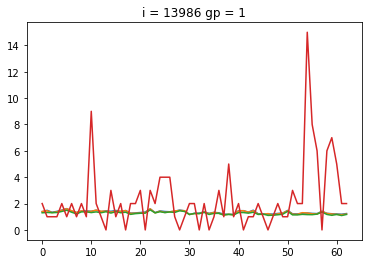

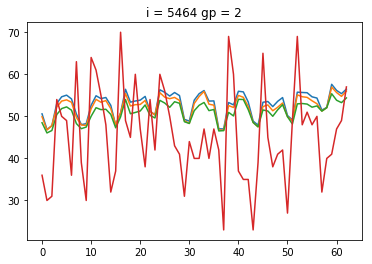

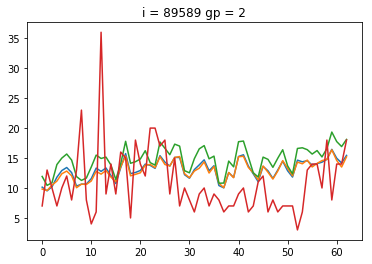

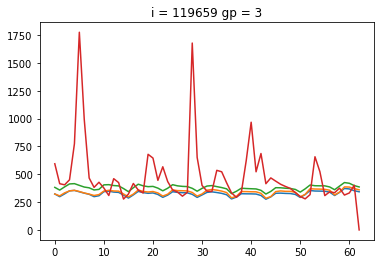

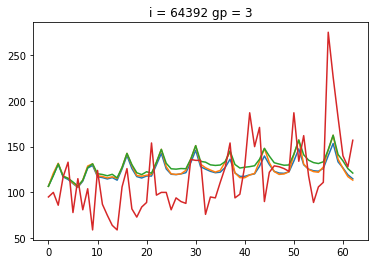

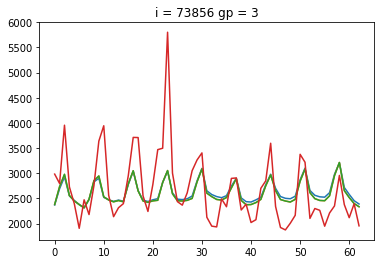

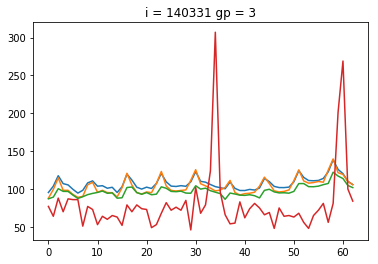

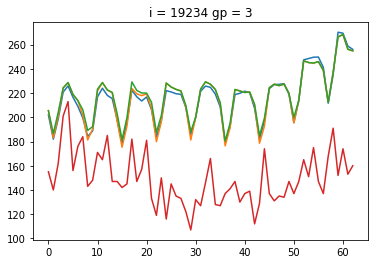

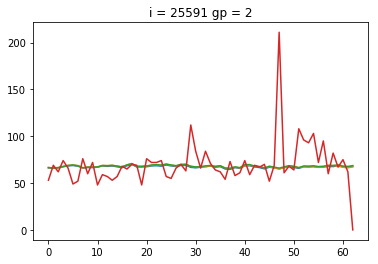

In [147]:
view_list = examine_list_gp((Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             Y_output_ori), output_gp, view_list=view_list)

## Case Study

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [148]:
view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

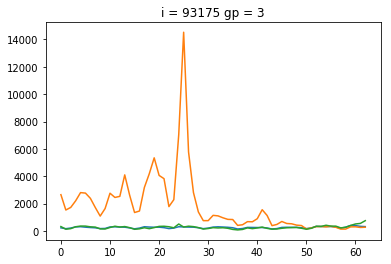

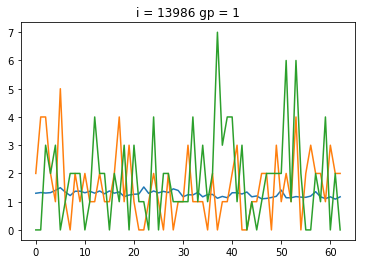

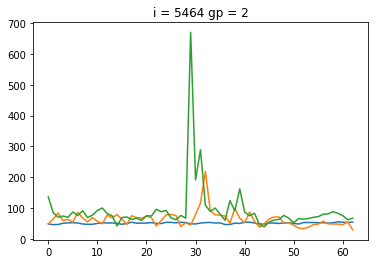

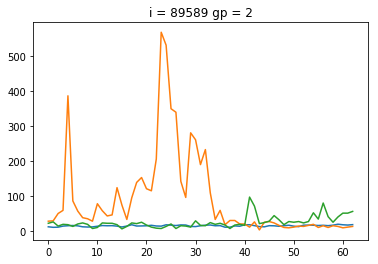

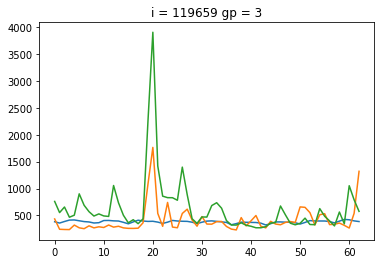

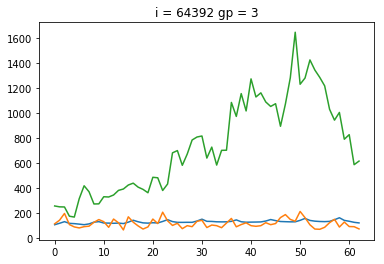

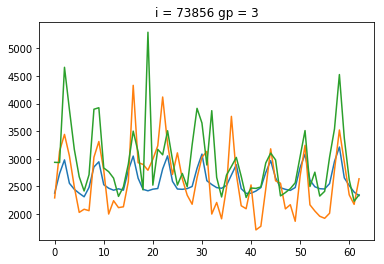

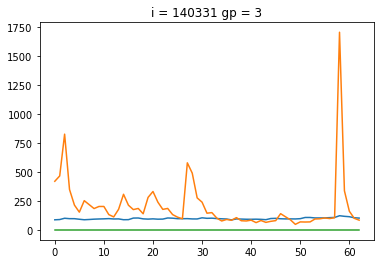

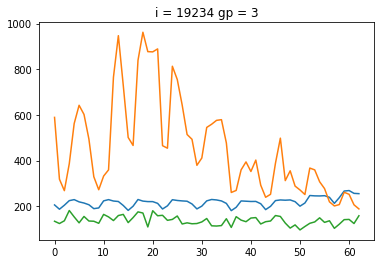

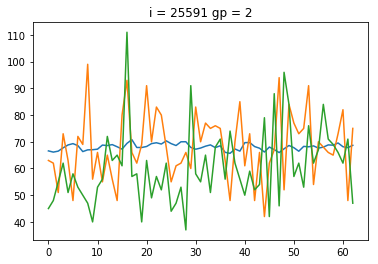

In [149]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

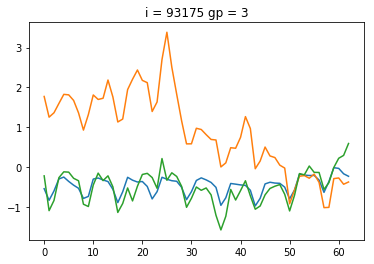

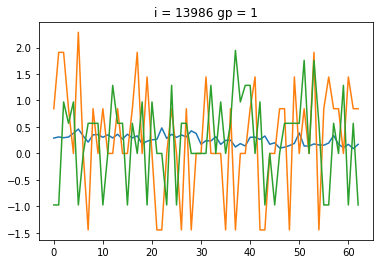

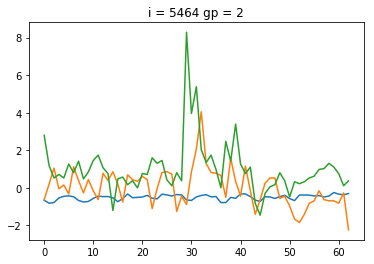

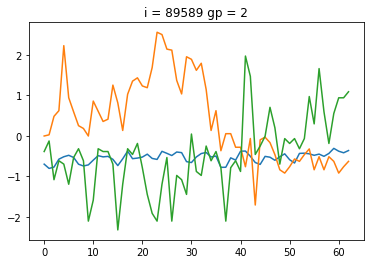

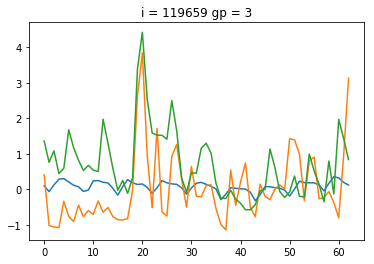

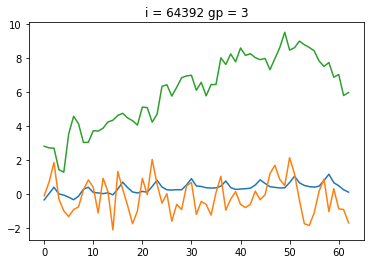

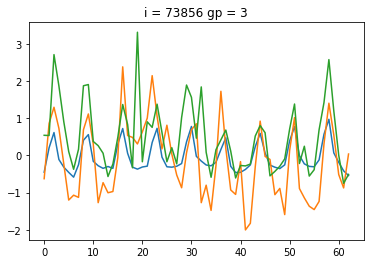

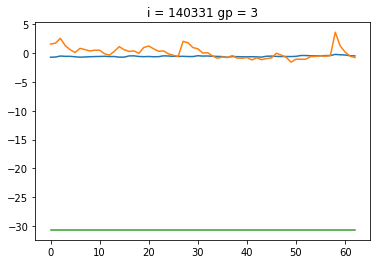

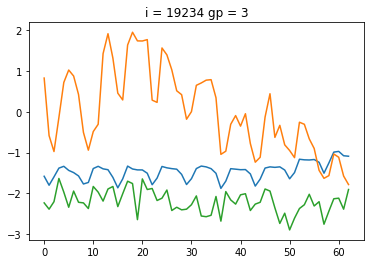

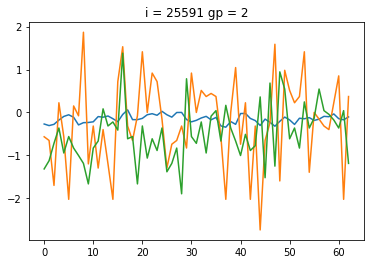

In [150]:
view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

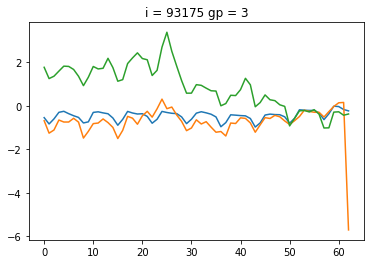

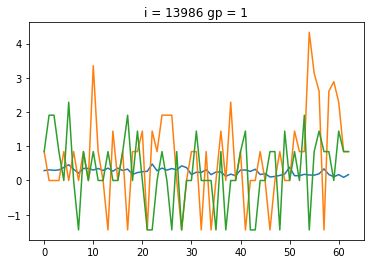

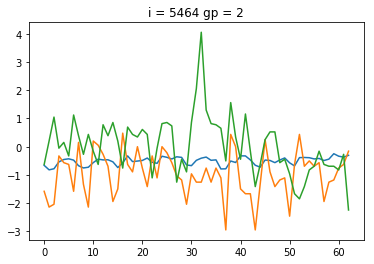

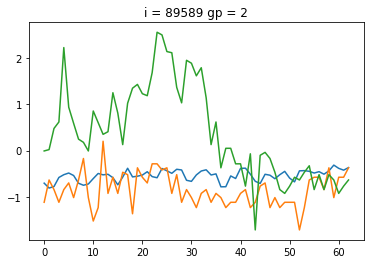

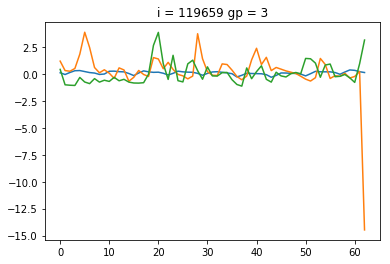

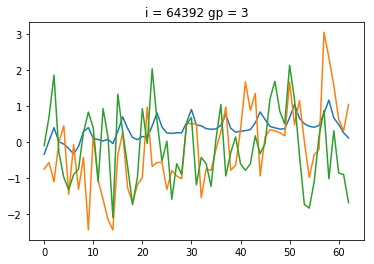

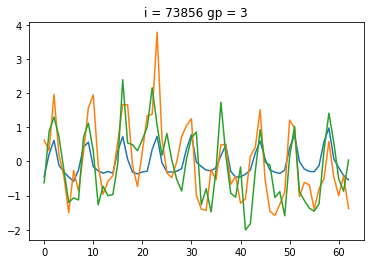

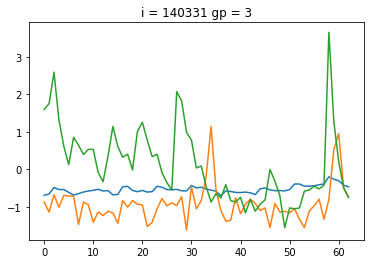

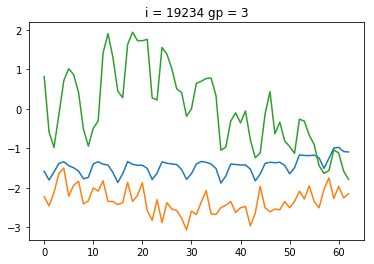

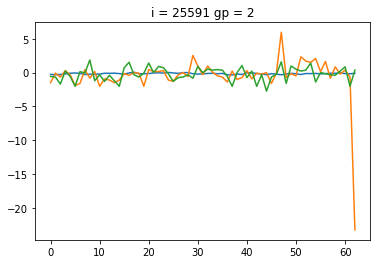

In [151]:
if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

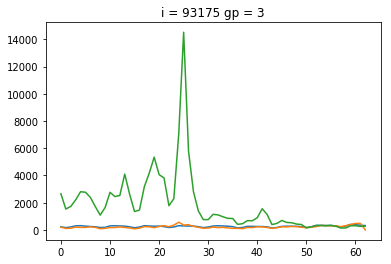

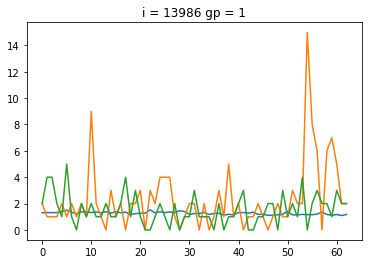

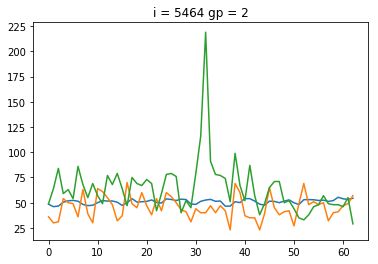

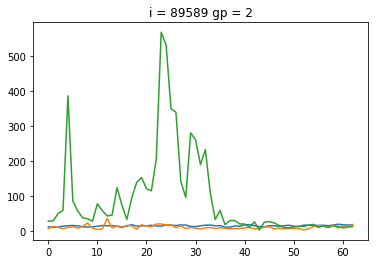

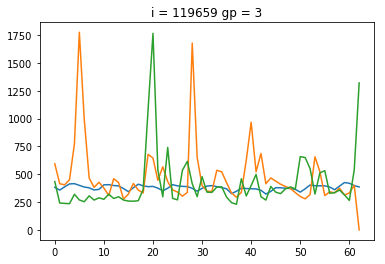

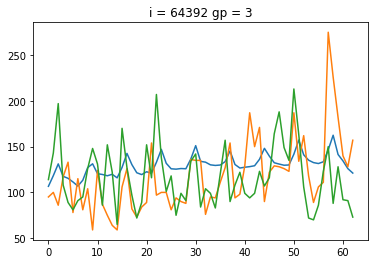

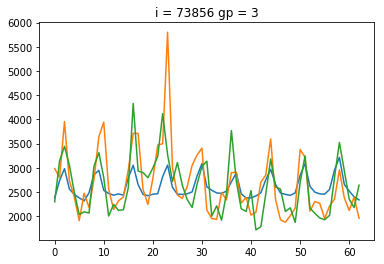

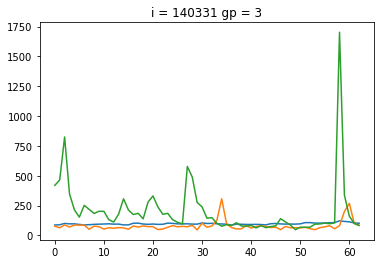

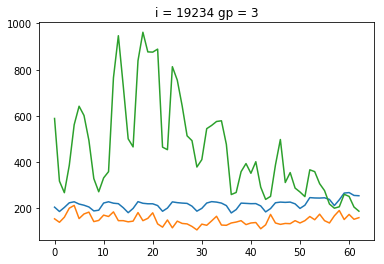

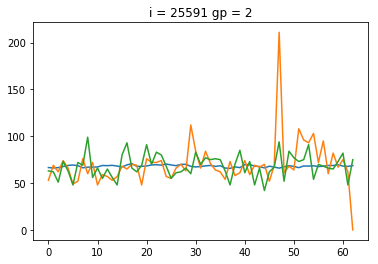

In [152]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

In [153]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[30.24248985868369,
 79.033035653684919,
 22.585594617846304,
 46.739288106580176,
 26.965786306084322,
 25.107752377605578,
 14.170974721256933,
 35.040407626248943,
 37.885154601586464,
 15.697656074659253]

In [154]:
view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

[True, False, True, False, True, True, True, True, True, True]

In [155]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[93175, 5464, 119659, 64392, 73856, 140331, 19234, 25591]

In [156]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[13986, 89589]

#### Good cases

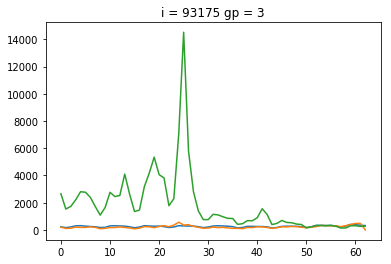

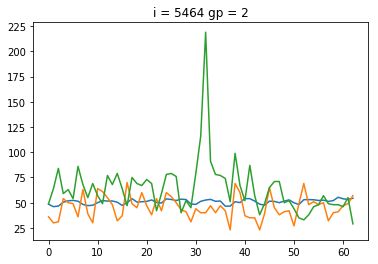

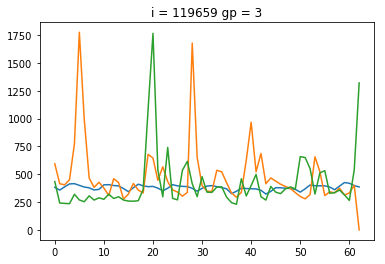

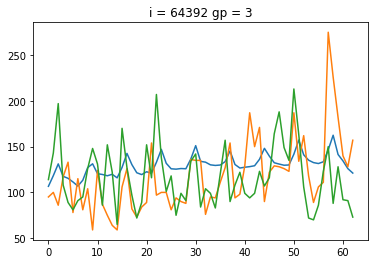

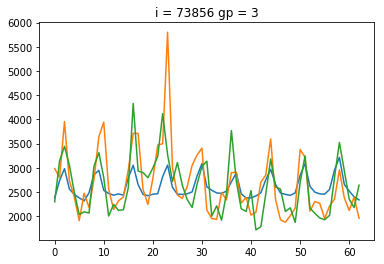

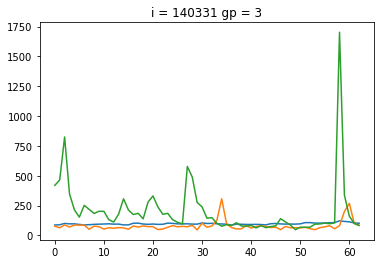

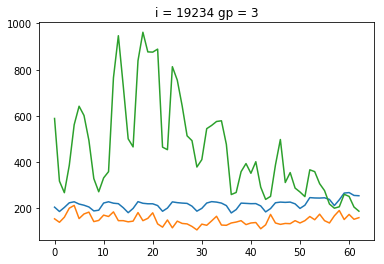

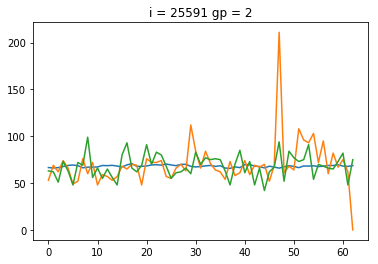

[93175, 5464, 119659, 64392, 73856, 140331, 19234, 25591]

In [157]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

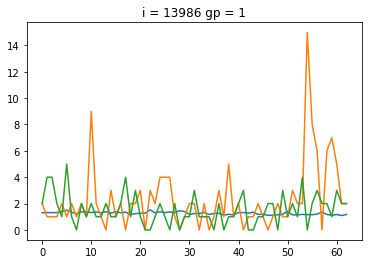

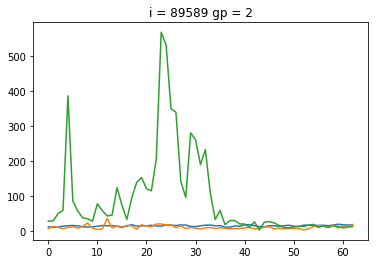

[13986, 89589]

In [158]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

In [159]:
print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

[ 2.61225391  1.78532984  2.56555268  2.07280115  3.41796964  2.14921911
  2.61489722  1.85125835]
[ 0.30103     1.46612587]


In [160]:
print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

[ 0.45758495  0.13744919  0.17725717  0.12048413  0.09144428  0.29619523
  0.18993217  0.07964336]
[ 0.20849044  0.50503777]


In [161]:
output_gp[view_list_good]

array([3, 2, 3, 3, 3, 3, 3, 2])

In [162]:
output_gp[view_list_bad]

array([1, 2])

In [163]:
gp_smape

[146.68448697339412,
 64.807984841647453,
 40.260705385303076,
 30.390158775548571,
 33.908285098297902,
 16.612689978177471]

In [164]:
gp_n

[1879, 23085, 43691, 75617, 740, 51]

#### Case 93175

In [165]:
i = 93175

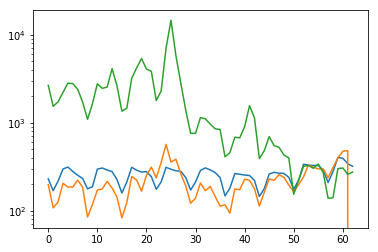

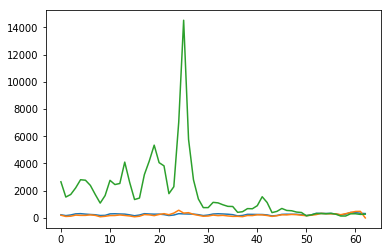

In [166]:
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

In [167]:
smape(Y_output_pred_ori[i], Y_output_raw[i])

30.24248985868369

In [168]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.61225391]),
 array([ 2.61225391]),
 array([ 0.4493528]),
 array([ 0.45758495]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

In [169]:
review_Y = np.array([score < model_smape for score in smape_Y_pred])

In [170]:
np.arange(len(Y_output_pred))

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [171]:
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; good_Y_index

array([     0,      3,      8, ..., 144962, 145021, 145042])

In [172]:
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; bad_Y_index

array([     1,      2,      4, ..., 145060, 145061, 145062])

In [173]:
good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

In [174]:
good_input_center = input_center[good_Y_index]
good_output_center = output_center[good_Y_index]
bad_input_center = input_center[bad_Y_index]
bad_output_center = output_center[bad_Y_index]

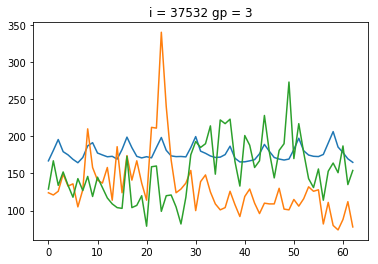

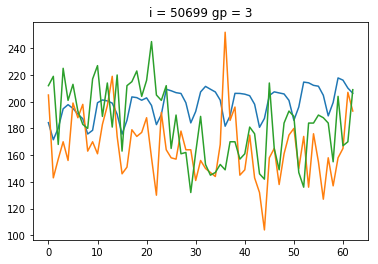

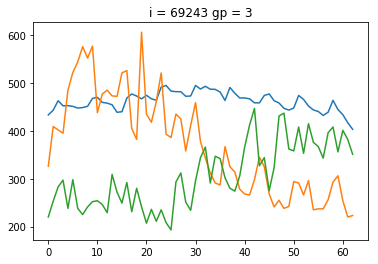

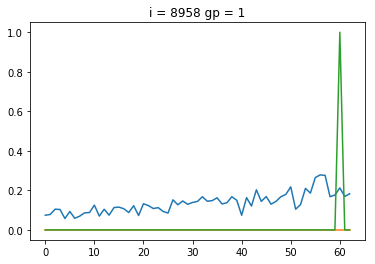

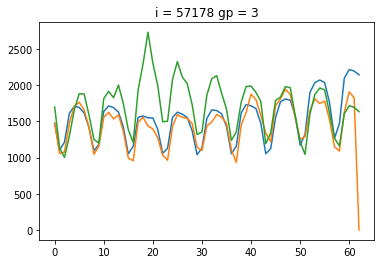

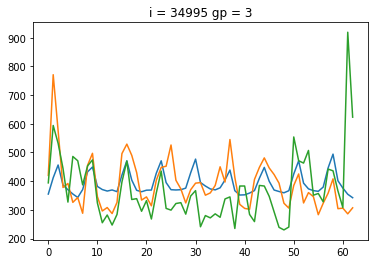

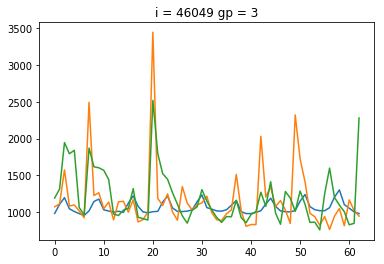

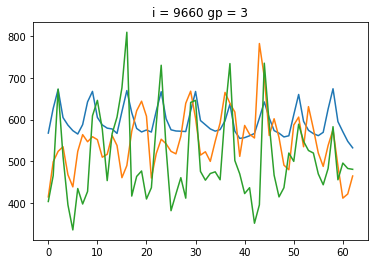

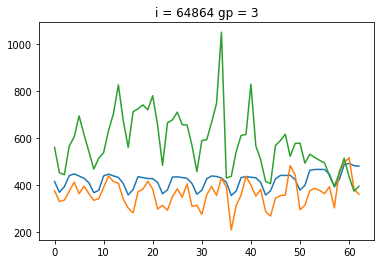

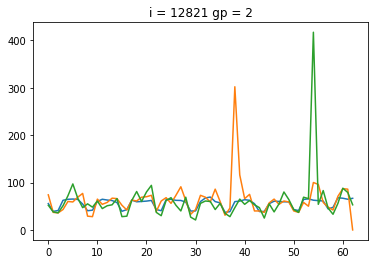

[37532, 50699, 69243, 8958, 57178, 34995, 46049, 9660, 64864, 12821]

In [175]:
good_view_list_sub = examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), 
                output_gp[good_Y_index])

The index in the plots are not original.

In [263]:
#Original index for the selected good view list
good_view_index = np.arange(len(Y_output_pred))[good_Y_index][good_view_list_sub]; good_view_index

array([ 61999,  81780, 107331,  13435,  91838,  58380,  73778,  16386,
       101598,  20636])

In [277]:
already_good_view_list_sub = [57178, 34995, 64864, 12821]

In [275]:
good_view_list_to_map = {good_view_list_sub[j]: good_view_index[j] for j in range(len(good_view_index))}

In [278]:
already_good = [good_view_list_to_map[x] for x in already_good_view_list_sub]; already_good

[91838, 58380, 73778, 101598, 20636]

#Original index
Could be better list: 16386(9660)
Already good list: 91838, 58380, 73778, 101598, 20636
Frequency not match: 73778 (46049)

#The following list obtain from plots in other case study section
Amplitude doesn't match: 16386, 5464, 64392, 73856, 140331, 19234

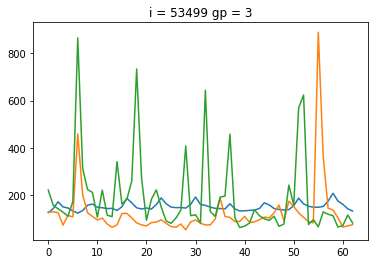

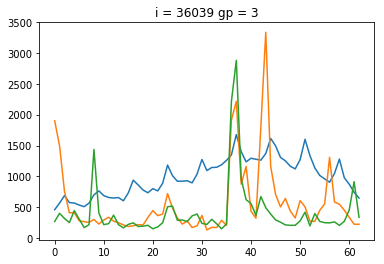

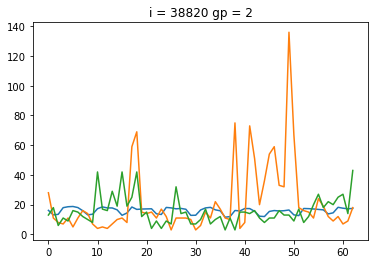

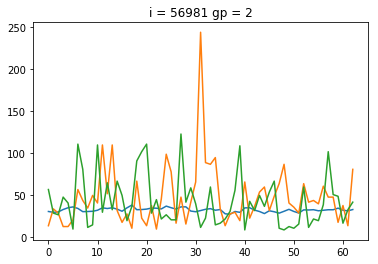

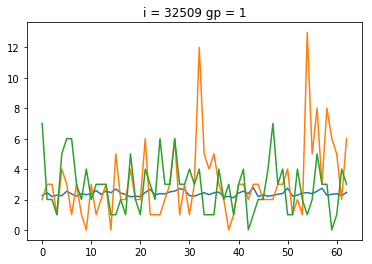

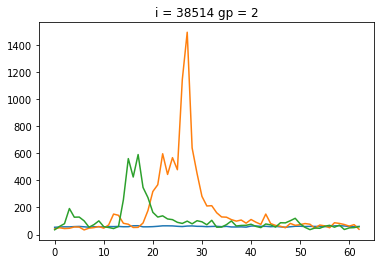

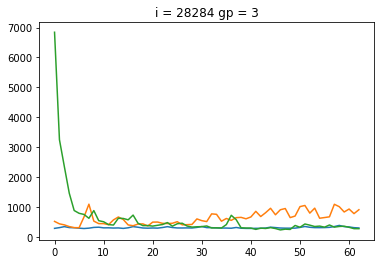

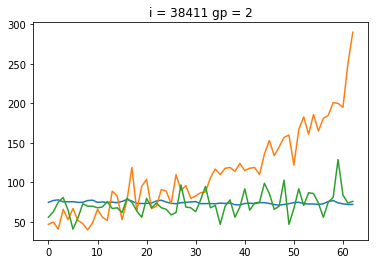

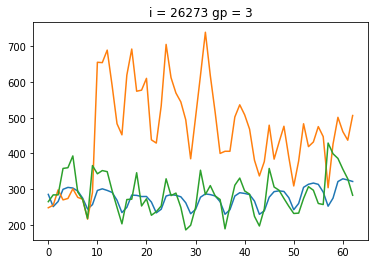

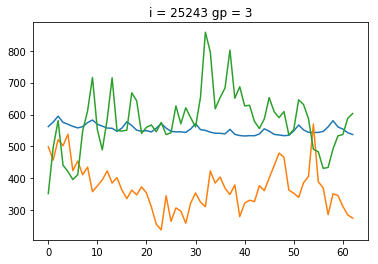

[53499, 36039, 38820, 56981, 32509, 38514, 28284, 38411, 26273, 25243]

In [176]:
examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

### Could be better cases study
There are some cases that the frequency is correctly learned but the amplitdue is not.

Amplitude doesn't match: 16386, 5464, 64392, 73856, 140331, 19234

Already good list: 91838, 58380, 73778, 101598, 20636

In [312]:
could_better = [16386, 5464, 64392, 73856, 140331, 19234]
already_good = [91838, 58380, 101598, 20636]
frequency_not_match = [73778]

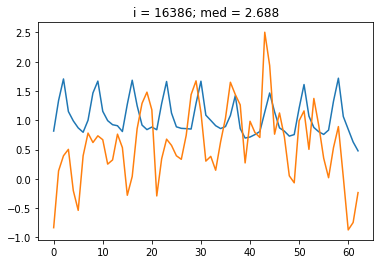

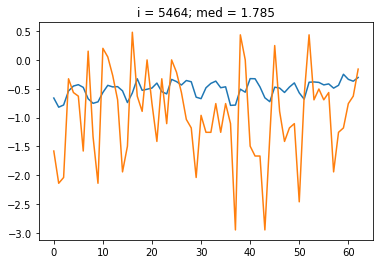

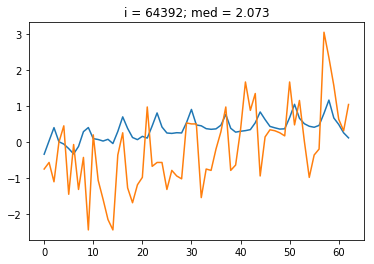

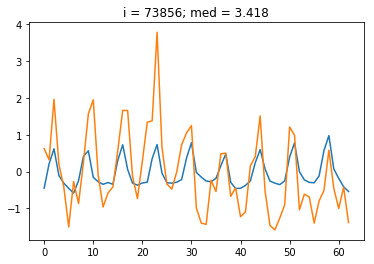

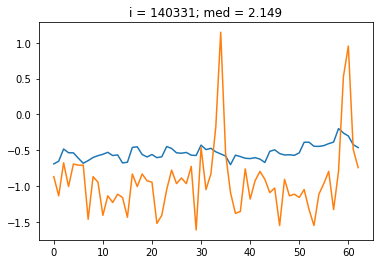

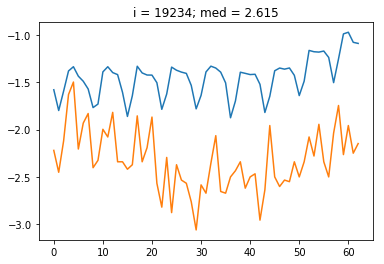

In [280]:
for i in could_better:
    plt.plot(Y_output_pred[i], label='predict')
    plt.plot(Y_output[i], label='true')
    plt.title('i = ' + str(i) + '; med = ' + '%.3f' % output_center[i, 0] )
    plt.show()

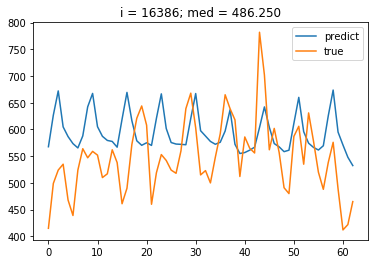

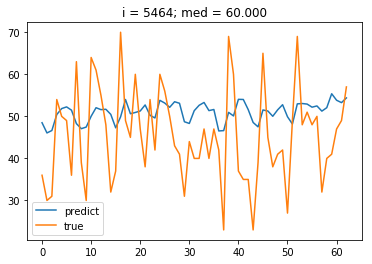

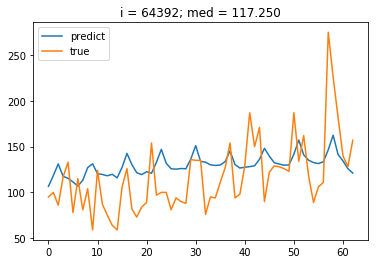

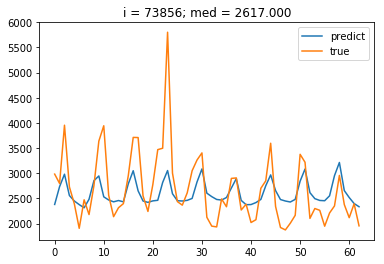

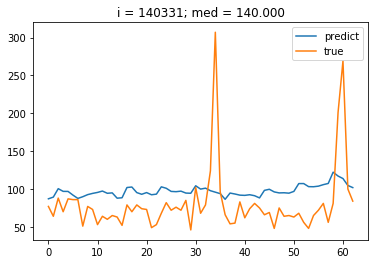

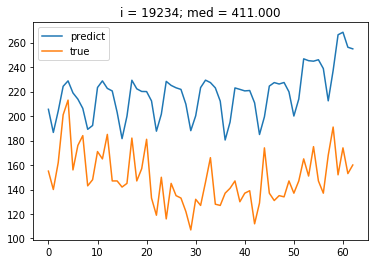

In [266]:
for i in could_better:
    plt.plot(Y_output_pred_ori[i], label='predict')
    plt.plot(Y_output_ori[i], label='true')
    plt.title('i = ' + str(i) + '; med = ' + '%.3f' % unlog(output_center[i, 0]) )
    plt.legend()
    plt.show()

#### Case 16386

In [267]:
could_better[0]

16386

In [268]:
i = 16386

In [269]:
output_center[i,0], output_scale[i,0]

(2.6877518477896589, 0.082332093928924072)

In [270]:
fib_output_median[i], unlog(output_center[i,0])

(486.25, 486.24999999999989)

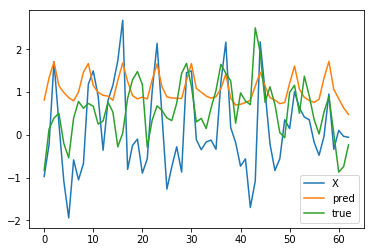

In [271]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.legend(); plt.show()

In [272]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(587.95747979412738, 402.10645614516767)

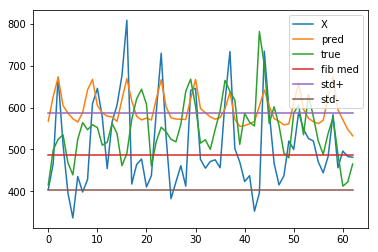

In [273]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

#### Case 64392

In [230]:
could_better[2]

64392

In [231]:
i = 64392

In [232]:
output_center[i,0], output_scale[i,0]

(2.0728011494098491, 0.12048413428855614)

In [233]:
fib_output_median[i], unlog(output_center[i,0])

(117.25, 117.24999999999997)

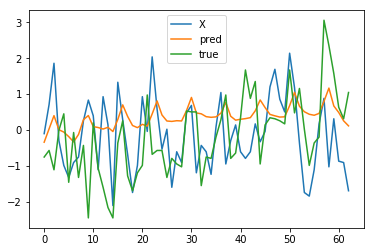

In [234]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.legend(); plt.show()

The true X and Y for case differ a lot so it is not model's fault.

In [235]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(155.05772938074645, 88.601857950171762)

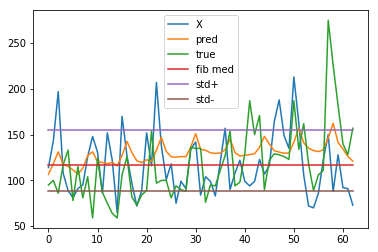

In [236]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

#### Case 73856

In [237]:
could_better[3]

73856

In [239]:
i = 73856

In [240]:
output_center[i,0], output_scale[i,0]

(3.4179696422147372, 0.091444278571418111)

In [241]:
fib_output_median[i], unlog(output_center[i,0])

(2617.0, 2617.0000000000014)

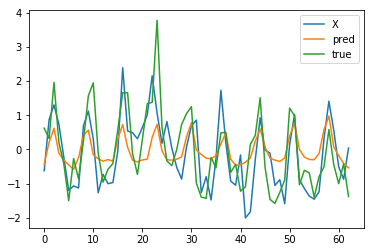

In [242]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.legend(); plt.show()

The neural net seems to confined in the range of (-1,1)

In [243]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(3230.5726269852612, 2119.9252556375445)

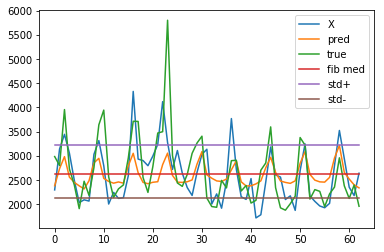

In [244]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

#### Case 91838 - Already Good

In [283]:
already_good[0]

91838

In [284]:
i = 91838

In [285]:
output_center[i,0], output_scale[i,0]

(3.2440914852008529, 0.094111649354036125)

In [286]:
fib_output_median[i], unlog(output_center[i,0])

(1753.25, 1753.2499999999991)

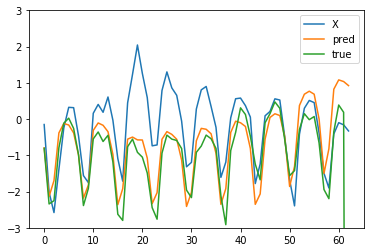

In [288]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.ylim([-3,3])
plt.legend(); plt.show()

In [289]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(2177.7286008100878, 1411.4719624811328)

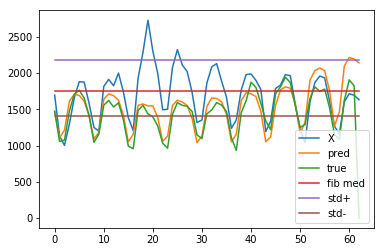

In [290]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

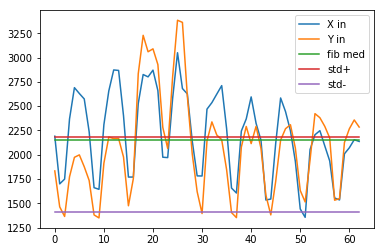

In [294]:
plt.plot(X_input_ori[i], label='X in')
plt.plot(Y_input_ori[i], label='Y in')
plt.plot(np.repeat(fib_input_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

#### Case 58380 - Already Good

In [295]:
already_good[1]

58380

In [296]:
i = 58380

In [297]:
output_center[i,0], output_scale[i,0]

(2.5526682161121932, 0.11755401579554538)

In [298]:
fib_output_median[i], unlog(output_center[i,0])

(356.0, 356.0)

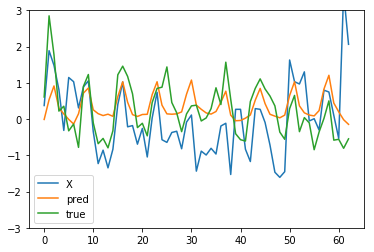

In [299]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.ylim([-3,3])
plt.legend(); plt.show()

In [300]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(466.97454629127674, 271.34173527180081)

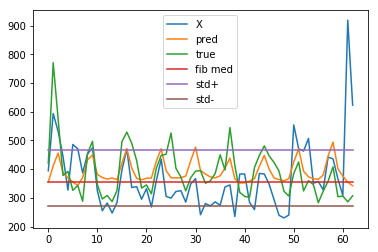

In [301]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

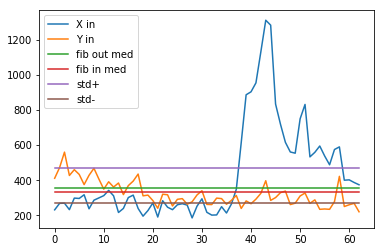

In [303]:
plt.plot(X_input_ori[i], label='X in')
plt.plot(Y_input_ori[i], label='Y in')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib out med')
plt.plot(np.repeat(fib_input_median[i], y_length), label='fib in med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

#### Case 101598 - Already Good

In [314]:
already_good[2]

101598

In [315]:
i = 101598

In [316]:
output_center[i,0], output_scale[i,0]

(2.7630534402996147, 0.090654981869166734)

In [317]:
fib_output_median[i], unlog(output_center[i,0])

(578.5, 578.49999999999989)

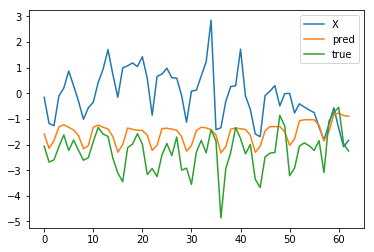

In [322]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
#plt.ylim([-3,3])
plt.legend(); plt.show()

In [319]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(713.01678654996431, 469.32542697299795)

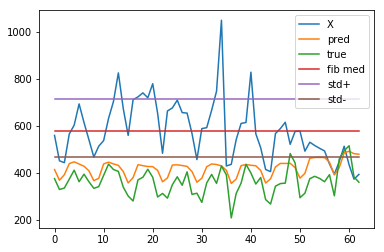

In [320]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

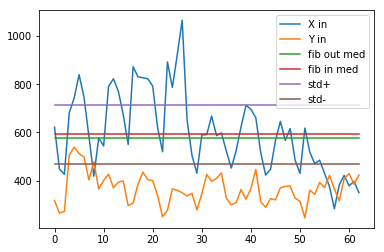

In [321]:
plt.plot(X_input_ori[i], label='X in')
plt.plot(Y_input_ori[i], label='Y in')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib out med')
plt.plot(np.repeat(fib_input_median[i], y_length), label='fib in med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

There is a seasonal dependent!

#### Case 73778 - Frequency not match (but good?)

In [313]:
frequency_not_match[0]

73778

In [305]:
i = 73778

In [306]:
output_center[i,0], output_scale[i,0]

(3.0493149525850809, 0.11641357302347528)

In [307]:
fib_output_median[i], unlog(output_center[i,0])

(1119.25, 1119.25)

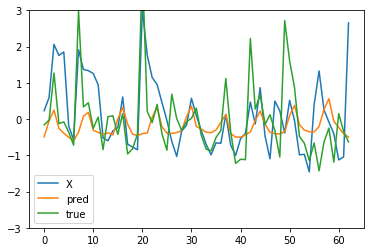

In [308]:
plt.plot(X_output[i], label='X')
plt.plot(Y_output_pred[i], label='pred')
plt.plot(Y_output[i], label='true')
plt.ylim([-3,3])
plt.legend(); plt.show()

In [309]:
logstd_p = unlog(untransform( 1, output_center[i,0], output_scale[i,0]))
logstd_m = unlog(untransform(-1, output_center[i,0], output_scale[i,0]))
logstd_p, logstd_m  # the +- 1 std in the original scale

(1463.6320236904153, 855.84324949955192)

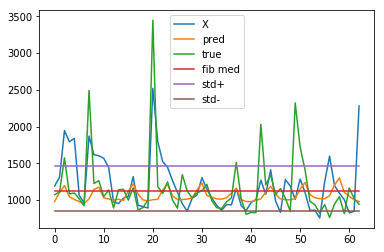

In [310]:
plt.plot(X_output_ori[i], label='X')
plt.plot(Y_output_pred_ori[i], label='pred')
plt.plot(Y_output_ori[i], label='true')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

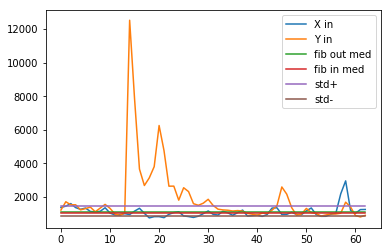

In [311]:
plt.plot(X_input_ori[i], label='X in')
plt.plot(Y_input_ori[i], label='Y in')
plt.plot(np.repeat(fib_output_median[i], y_length), label='fib out med')
plt.plot(np.repeat(fib_input_median[i], y_length), label='fib in med')
plt.plot(np.repeat(logstd_p, y_length), label='std+')
plt.plot(np.repeat(logstd_m, y_length), label='std-')
plt.legend(); plt.show()

### Other statistics

In [177]:
good_output_scale.min(), good_output_scale.max()

(0.0053654329977268714, 1.3484600516008696)

In [178]:
bad_output_scale.min(), bad_output_scale.max()

(0.0016980961003407436, 2.0382773961171501)

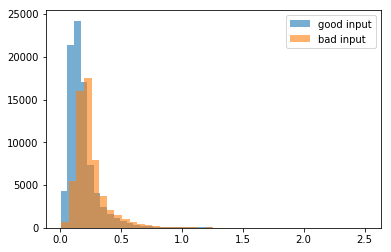

In [179]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

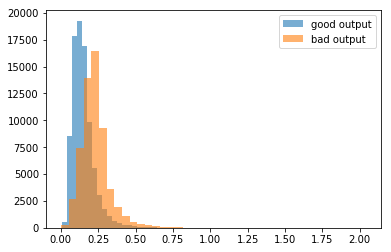

In [180]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

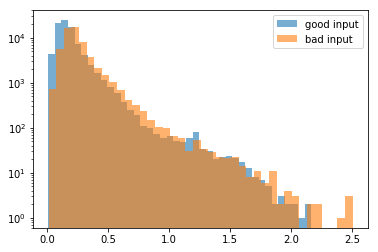

In [181]:
plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

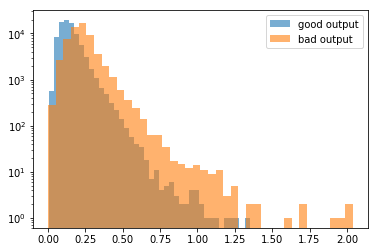

In [182]:
plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

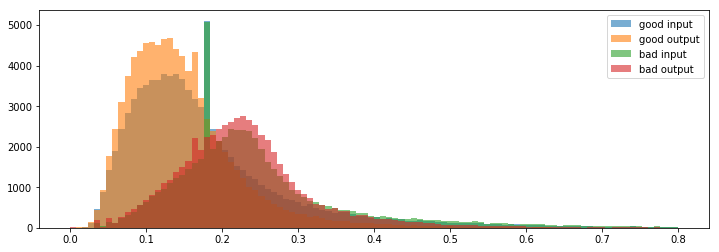

In [183]:
plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

In [184]:
np.mean(good_output_scale), np.mean(good_input_scale)

(0.14770542511492984, 0.18752240334292894)

In [185]:
np.mean(bad_output_scale), np.mean(bad_input_scale)

(0.23066816965317985, 0.25770890720655992)

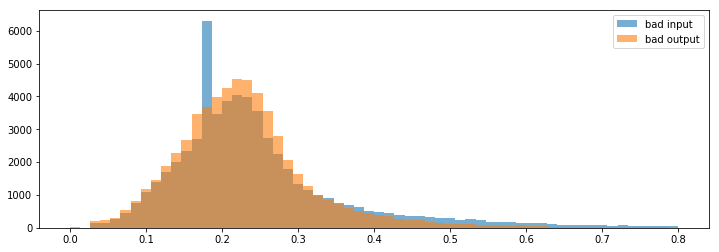

In [186]:
plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

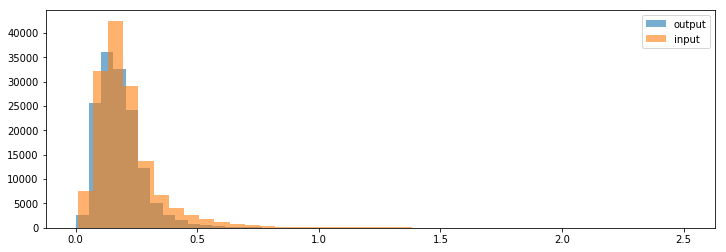

In [187]:
plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

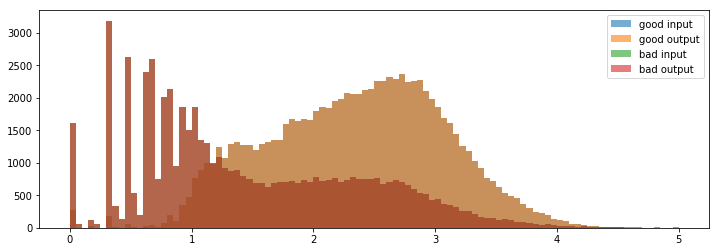

In [188]:
plt.figure(figsize=(12,4))
plt.hist(good_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

In [189]:
gc.collect()

69660

### stdev/median

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [190]:
Y_output_dates

Index(['2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
       '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
       '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14',
       '2017-07-15', '2017-07-16', '2017-07-17', '2017-07-18', '2017-07-19',
       '2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
       '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
       '2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
       '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08',
       '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
       '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
       '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28',
       '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')

In [191]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_fmc_ori, columns = Y_output_dates)  # using combined result
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]